In [1]:
######### optimized GCN


In [1]:
import os
import sys
import urllib.request
import time


from pandas import read_csv
from datetime import datetime

import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Input, Lambda, Dropout, Reshape, Layer, Permute
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, optimizers, losses, metrics, Model


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import matplotlib.patches as mpatches



In [2]:
import stellargraph as sg
from stellargraph.mapper import SlidingFeaturesNodeGenerator
from stellargraph.core.experimental import experimental
from stellargraph.core.utils import calculate_laplacian

2024-10-29 15:02:03.671233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_Canal_h = pd.read_csv('~/Desktop/Thesis/Data/Clean-Data-Dijon/Canal_h.csv',
  parse_dates=['Timestamp'],
  index_col="Timestamp")

df_Hoche_h = pd.read_csv('~/Desktop/Thesis/Data/Clean-Data-Dijon/Hoche_h.csv',
  parse_dates=['Timestamp'],
  index_col="Timestamp")

df_Carnot_h = pd.read_csv('~/Desktop/Thesis/Data/Clean-Data-Dijon/Carnot_h.csv',
  parse_dates=['Timestamp'],
  index_col="Timestamp")

df_Janin_h = pd.read_csv('~/Desktop/Thesis/Data/Clean-Data-Dijon/Janin_h.csv',
  parse_dates=['Timestamp'],
  index_col="Timestamp")

df_20years = pd.read_csv('~/Desktop/Thesis/Data/DijonJerome/Data.csv',
  parse_dates=['Date'],
  index_col="Date")

In [4]:
df_20years['bldep'].replace({'--': None},inplace =True)

In [5]:
df_20years.fillna(method='ffill', inplace=True)

In [6]:
df_20years = df_20years.drop(['psl'], axis=1)
df_20years = df_20years.drop(['bldep'], axis=1)
df_20years

,Latitude,Longitude,od1000aer,od550aer,ssa550aer,asy550aer,pm1,pm25,pm10,hurs,tas,uas,vas
Date,,,,,,,,,,,,,
2000-01-01 01:00:00,47.33,5.02,0.025302,0.061533,0.972928,0.755690,3.889120e-09,4.416584e-09,5.994657e-09,99.767235,274.36765,0.575817,4.412967
2000-01-01 02:00:00,47.33,5.02,0.025661,0.063846,0.972175,0.751743,3.260840e-09,3.737777e-09,5.163415e-09,98.191246,274.58606,0.834132,4.972153
2000-01-01 03:00:00,47.33,5.02,0.039914,0.098720,0.977064,0.755439,3.296795e-09,3.780420e-09,5.227162e-09,96.380990,274.81440,0.479268,5.664875
2000-01-01 04:00:00,47.33,5.02,0.061989,0.151278,0.980473,0.759764,3.517032e-09,4.028821e-09,5.559584e-09,97.007710,274.70862,0.503862,6.210927
2000-01-01 05:00:00,47.33,5.02,0.057831,0.141564,0.976921,0.759195,3.979243e-09,4.552968e-09,6.268784e-09,97.222780,274.88336,1.006827,6.033845
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 20:00:00,47.33,5.02,0.050517,0.148701,0.982503,0.619178,1.349635e-08,1.611301e-08,2.406288e-08,67.151690,285.49966,2.350283,-0.587834
2021-03-31 21:00:00,47.33,5.02,0.051146,0.150976,0.982463,0.619597,1.400676e-08,1.679083e-08,2.534295e-08,71.428510,284.36752,2.213150,-0.419304
2021-03-31 22:00:00,47.33,5.02,0.051796,0.152926,0.982833,0.624350,1.523392e-08,1.823990e-08,2.742958e-08,74.570160,283.40756,1.981903,0.062305


In [7]:
df_20years = df_20years.astype('float32')
df_20years = df_20years.iloc[:, 6:11]

In [8]:
df_20years['pm1'] *= 1e9
df_20years['pm25'] *= 1e9
df_20years['pm10'] *= 1e9
df_20years['tas'] -= 273

In [9]:
df_20years

,pm1,pm25,pm10,hurs,tas
Date,,,,,
2000-01-01 01:00:00,3.889120,4.416584,5.994657,99.767235,1.367645
2000-01-01 02:00:00,3.260840,3.737777,5.163415,98.191246,1.586060
2000-01-01 03:00:00,3.296795,3.780420,5.227162,96.380989,1.814392
2000-01-01 04:00:00,3.517032,4.028821,5.559584,97.007713,1.708618
2000-01-01 05:00:00,3.979243,4.552968,6.268784,97.222778,1.883362
...,...,...,...,...,...
2021-03-31 20:00:00,13.496349,16.113012,24.062883,67.151688,12.499664
2021-03-31 21:00:00,14.006757,16.790829,25.342947,71.428513,11.367523
2021-03-31 22:00:00,15.233917,18.239899,27.429577,74.570160,10.407562


In [10]:
df_20years.rename(columns={'pm1': 'PM1_SW12', 'pm25': 'PM25_SW12', 'pm10': 'PM10_SW12', 'hurs': 'RH', 'tas': 'Temp' }, inplace=True)
df_jerome = df_20years.loc['2018-10-29 23:00:00':'2019-11-01 00:00:00']

In [11]:
full_index = pd.date_range(start=df_jerome.index.min(0), end=df_jerome.index.max(-1), freq='H')
df_jerome = df_jerome.reindex(full_index)
df_jerome.fillna(method='ffill', inplace=True)
df_jerome.index.name = 'timestamp'

df_jerome

,PM1_SW12,PM25_SW12,PM10_SW12,RH,Temp
timestamp,,,,,
2018-10-29 23:00:00,0.996506,1.129745,1.528631,97.440201,1.494293
2018-10-30 00:00:00,0.937902,1.057327,1.415633,94.379379,1.559875
2018-10-30 01:00:00,1.191396,1.348007,1.817859,99.155464,0.721985
2018-10-30 02:00:00,1.071654,1.211778,1.632199,99.629974,0.456055
2018-10-30 03:00:00,0.997071,1.129810,1.528036,99.474838,0.359283
...,...,...,...,...,...
2019-10-31 20:00:00,4.289314,4.957255,6.933590,100.000000,9.616547
2019-10-31 21:00:00,3.859734,4.477681,6.289125,100.000000,9.907684
2019-10-31 22:00:00,4.082632,4.753823,6.710828,100.000000,10.054718


In [12]:
def add_col(df):
    
    df['hour'] = df.index.hour
#     df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
#     df['month'] = df.index.month

In [13]:
add_col(df_jerome)
df_jerome

,PM1_SW12,PM25_SW12,PM10_SW12,RH,Temp,hour,day_of_week
timestamp,,,,,,,
2018-10-29 23:00:00,0.996506,1.129745,1.528631,97.440201,1.494293,23,0
2018-10-30 00:00:00,0.937902,1.057327,1.415633,94.379379,1.559875,0,1
2018-10-30 01:00:00,1.191396,1.348007,1.817859,99.155464,0.721985,1,1
2018-10-30 02:00:00,1.071654,1.211778,1.632199,99.629974,0.456055,2,1
2018-10-30 03:00:00,0.997071,1.129810,1.528036,99.474838,0.359283,3,1
...,...,...,...,...,...,...,...
2019-10-31 20:00:00,4.289314,4.957255,6.933590,100.000000,9.616547,20,3
2019-10-31 21:00:00,3.859734,4.477681,6.289125,100.000000,9.907684,21,3
2019-10-31 22:00:00,4.082632,4.753823,6.710828,100.000000,10.054718,22,3


In [14]:
def missing_values_table(df):
        #zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        #mis_val_percent = 100 * df.isnull().sum() / len(df)
        Total_val = df.shape
        mz_table = pd.DataFrame(mis_val)
        mz_table = mz_table.rename(
        columns = {0 : 'Missing Values', 1 : 'of Total Values'})
        
        mz_table['of Total Values']= Total_val[0]
                
        #mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Missing Values'] = 100 * mz_table['Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,2] != 0].sort_values(
        '% Total Missing Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [15]:
# df_Canal_test = pd.read_csv('~/Desktop/Thesis/Data/Dijon/new/df_Canal_h.csv',
#   parse_dates=['timestamp'],
#   index_col="timestamp")

# df_Hoche_test = pd.read_csv('~/Desktop/Thesis/Data/Dijon/new/df_Hoche_h.csv',
#   parse_dates=['timestamp'],
#   index_col="timestamp")

# df_Carnot_test = pd.read_csv('~/Desktop/Thesis/Data/Dijon/new/df_Carnot_h.csv',
#   parse_dates=['timestamp'],
#   index_col="timestamp")

In [16]:
# df_Canal_test = df_Canal_test['2021-11-01 02:00:00':'2022-01-10 01:00:00']
# df_Hoche_test = df_Hoche_test['2021-11-01 02:00:00':'2022-01-10 01:00:00']
# df_Carnot_test = df_Carnot_test['2021-11-01 02:00:00':'2022-01-10 01:00:00']

# # Janin_60_h = Janin_60_h['2021-11-01 02:00:00':'2021-09-11 10:00:00']

In [17]:
def missing_values_table(df):
        #zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        #mis_val_percent = 100 * df.isnull().sum() / len(df)
        Total_val = df.shape
        mz_table = pd.DataFrame(mis_val)
        mz_table = mz_table.rename(
        columns = {0 : 'Missing Values', 1 : 'of Total Values'})
        
        mz_table['of Total Values']= Total_val[0]
        
        #mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Missing Values'] = 100 * mz_table['Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,2] != 0].sort_values(
        '% Total Missing Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [18]:
df_Canal_h.shape, df_Hoche_h.shape, df_Carnot_h.shape, df_Janin_h.shape

((8810, 14), (8810, 14), (8810, 14), (8810, 14))

In [19]:
# df_Canal_test.shape, df_Hoche_test.shape, df_Carnot_test.shape

In [20]:
df_Canal_h.fillna(method='ffill', inplace=True)
df_Hoche_h.fillna(method='ffill', inplace=True)
df_Carnot_h.fillna(method='ffill', inplace=True)
df_Janin_h.fillna(method='ffill', inplace=True)

In [21]:
df_Canal_h.iloc[0:5, 5:15]

,PM1_SW12,PM25_SW12,PM10_SW12,Temp_SW12,RH_SW12,hour,day_of_month,day_of_week,month
Timestamp,,,,,,,,,
2020-10-29 23:00:00,4.6325,6.2700,6.805000,13.204999,87.699997,23,29,3,10
2020-10-30 00:00:00,4.9700,7.3150,7.967500,13.032500,88.950005,0,30,4,10
2020-10-30 01:00:00,4.0125,5.7800,6.037499,12.969999,89.049995,1,30,4,10
2020-10-30 02:00:00,3.0275,4.6625,5.560000,13.095000,88.566673,2,30,4,10
2020-10-30 03:00:00,2.7075,4.4575,5.432500,13.095000,88.425003,3,30,4,10


In [22]:
# df_Canal_test.fillna(method='ffill', inplace=True)
# df_Hoche_test.fillna(method='ffill', inplace=True)
# df_Carnot_test.fillna(method='ffill', inplace=True)

In [23]:
# df_Canal_test = df_Canal_test.iloc[:, 5:10]
# df_Hoche_test = df_Hoche_test.iloc[:, 5:10]
# df_Carnot_test = df_Carnot_test.iloc[:, 5:10]

In [24]:
df_0 = df_Canal_h.iloc[:, 5:10]
df_1 = df_Hoche_h.iloc[:, 5:10]
df_2 = df_Carnot_h.iloc[:, 5:10]
df_3 = df_Janin_h.iloc[:, 5:10]

In [25]:
ex_column = 'hour'

df_0.insert(5, ex_column, df_Canal_h[ex_column], True)
df_1.insert(5, ex_column, df_Hoche_h[ex_column], True)
df_2.insert(5, ex_column, df_Carnot_h[ex_column], True)
df_3.insert(5, ex_column, df_Janin_h[ex_column], True)

In [26]:
ex_column = 'day_of_week'

df_0.insert(6, ex_column, df_Canal_h[ex_column], True)
df_1.insert(6, ex_column, df_Hoche_h[ex_column], True)
df_2.insert(6, ex_column, df_Carnot_h[ex_column], True)
df_3.insert(6, ex_column, df_Janin_h[ex_column], True)

In [27]:
df_0

,PM1_SW12,PM25_SW12,PM10_SW12,Temp_SW12,RH_SW12,hour,day_of_week
Timestamp,,,,,,,
2020-10-29 23:00:00,4.6325,6.2700,6.805000,13.204999,87.699997,23,3
2020-10-30 00:00:00,4.9700,7.3150,7.967500,13.032500,88.950005,0,4
2020-10-30 01:00:00,4.0125,5.7800,6.037499,12.969999,89.049995,1,4
2020-10-30 02:00:00,3.0275,4.6625,5.560000,13.095000,88.566673,2,4
2020-10-30 03:00:00,2.7075,4.4575,5.432500,13.095000,88.425003,3,4
...,...,...,...,...,...,...,...
2021-10-31 20:00:00,3.5300,4.4500,4.670000,14.060000,99.900002,20,6
2021-10-31 21:00:00,3.5300,4.4500,4.670000,14.060000,99.900002,21,6
2021-10-31 22:00:00,3.5300,4.4500,4.670000,14.060000,99.900002,22,6


In [28]:
# df_Canal_test.rename(columns={'PM1_MW12': 'PM1_SW12', 'PM2.5_MW12': 'PM25_SW12', 
#                              'PM10_MW12': 'PM10_SW12', 'RH_MW12': 'RH_SW12',
#                              'Temperature_MW12': 'Temp_SW12'}, inplace=True)
# df_Hoche_test.rename(columns={'PM1_MW12': 'PM1_SW12', 'PM2.5_MW12': 'PM25_SW12', 
#                              'PM10_MW12': 'PM10_SW12', 'RH_MW12': 'RH_SW12',
#                              'Temperature_MW12': 'Temp_SW12'}, inplace=True)
# df_Carnot_test.rename(columns={'PM1_MW12': 'PM1_SW12', 'PM2.5_MW12': 'PM25_SW12', 
#                              'PM10_MW12': 'PM10_SW12', 'RH_MW12': 'RH_SW12',
#                              'Temperature_MW12': 'Temp_SW12'}, inplace=True)

In [29]:
# df_0 = pd.concat([df_Canal_h, df_Canal_test])
# df_1 = pd.concat([df_Hoche_h, df_Hoche_test])
# df_2 = pd.concat([df_Carnot_h, df_Carnot_test])
# df_3 = pd.concat([df_Janin_h, df_Canal_test])

In [30]:
df_0 = df_0.astype('float32')
df_1 = df_1.astype('float32')
df_2 = df_2.astype('float32')
df_3 = df_3.astype('float32')

In [31]:
df_len = df_0.shape[1]
df_len

7

In [32]:
df_jerome.index = df_1.index
df_jerome

,PM1_SW12,PM25_SW12,PM10_SW12,RH,Temp,hour,day_of_week
Timestamp,,,,,,,
2020-10-29 23:00:00,0.996506,1.129745,1.528631,97.440201,1.494293,23,0
2020-10-30 00:00:00,0.937902,1.057327,1.415633,94.379379,1.559875,0,1
2020-10-30 01:00:00,1.191396,1.348007,1.817859,99.155464,0.721985,1,1
2020-10-30 02:00:00,1.071654,1.211778,1.632199,99.629974,0.456055,2,1
2020-10-30 03:00:00,0.997071,1.129810,1.528036,99.474838,0.359283,3,1
...,...,...,...,...,...,...,...
2021-10-31 20:00:00,4.289314,4.957255,6.933590,100.000000,9.616547,20,3
2021-10-31 21:00:00,3.859734,4.477681,6.289125,100.000000,9.907684,21,3
2021-10-31 22:00:00,4.082632,4.753823,6.710828,100.000000,10.054718,22,3


In [33]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_df_0 = scaler.fit_transform(df_0)
# scaled_df_1 = scaler.fit_transform(df_1)
# scaled_df_2 = scaler.fit_transform(df_2)
# scaled_df_3 = scaler.fit_transform(df_3)


In [34]:
def multiplot_df(*DFs, x , y, x_num, x_label, title='_'):
    
    plt.figure(figsize=(8, 3))
    
    for df in DFs:

        ax = sns.lineplot(x = x, y = df[y],
                         data = df, legend='brief')
        
   
    plt.xticks(rotation=65, horizontalalignment='right')
    plt.xticks(ticks=x_num, labels=x_label , size=10, rotation=90) if len(x_num)!=0 else None
    plt.legend(['Canal', 'Hoche',  'Carnot', 'Janin', 'Jerome'],bbox_to_anchor=(0.84, 1), loc='upper left', borderaxespad=0,
              fontsize=10)
    plt.title('PM2.5 Concentrations Variation Across Hours of a Day', fontsize=12)
    plt.ylabel(ylabel="PM1", fontsize=10)
    plt.xlabel(xlabel="hour_of_day", fontsize=10)
    
    

    plt.show()

In [35]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekdays_num = [0, 1, 2, 3, 4, 5, 6]

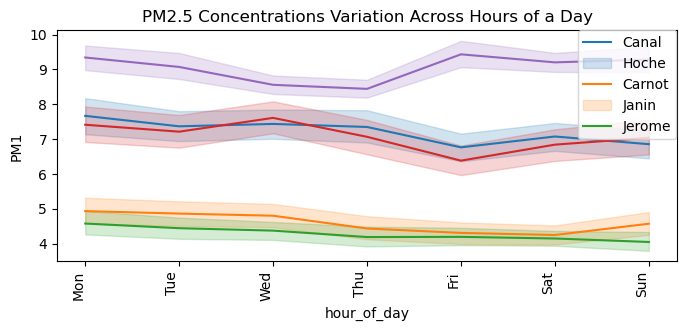

In [36]:
multiplot_df(df_0, df_1, df_2, df_3, df_jerome, x = 'day_of_week',
             y='PM25_SW12', x_num = weekdays_num, x_label= weekdays, title='day_of_week')

In [37]:
# monthdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
             17, 18, 19, 20, 21, 22, 23]

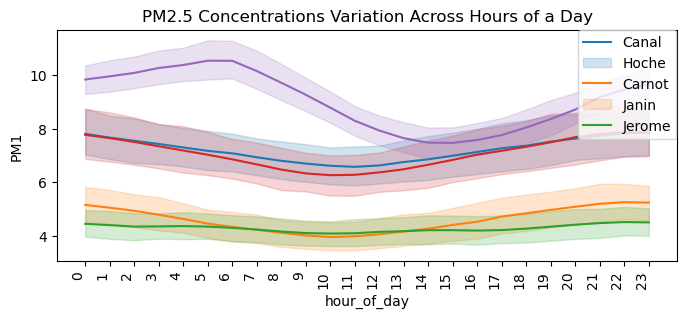

In [38]:
multiplot_df(df_0, df_1, df_2, df_3, df_jerome, x = 'hour',
             y='PM25_SW12', x_num = hours, x_label= hours, title='hours')

In [39]:
def MinMaxScaler_fun (df):  
    
    scale_dict = {}

    scaled_df = np.empty([df.shape[0], df.shape[1]])
    for c in range(len(df.columns)):
 
             ##### df = np.round(df, 4)
        max_val = np.max(df.iloc[:, c])
        min_val = np.min(df.iloc[:, c])
        
                
        scaled_df[:, c] = (df.iloc[:, c] - min_val) / (max_val - min_val) 
        scale_dict[str(c)] = [max_val, min_val] 
        
    return scale_dict, scaled_df

In [40]:

dict_scaler0, scaled_df_0 = MinMaxScaler_fun(df_0)
dict_scaler1, scaled_df_1 = MinMaxScaler_fun(df_1)
dict_scaler2, scaled_df_2 = MinMaxScaler_fun(df_2)
dict_scaler3, scaled_df_3 = MinMaxScaler_fun(df_3)
dict_scalerJ, scaled_df_jerome = MinMaxScaler_fun(df_jerome)

In [41]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    
	"""Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [42]:
def data_frame(df, seq_len=1, pre_len=1, target_out=0):

    
#     df = df[:, num_dataset*5:(num_dataset+1)*5]
    reframed = series_to_supervised(df, pre_len, seq_len)
    # drop columns we don't want to predict
    df_copy = reframed.copy()
    
    for i in range(len(reframed.columns)):

        if (i >= (pre_len*df_len)) and (np.remainder(i,df_len) != target_out):  ## != 0 PM1, !=1 PM2.5, !=2 PM10

            col_name = reframed.columns[i]
            df_copy.drop([col_name], axis=1, inplace=True)


    print(df_copy.head())
    return df_copy

In [43]:
pre_len = 1  # forecasting   for each 6 hous pre -> 1 hour seq  --minimum 3 hours
seq_len = 3  # observations 

# pre_len = 6
# seq_len = 4

# pre_len = 12
# seq_len = 5

# pre_len = 24
# seq_len = 7

# pre_len = 36
# seq_len = 9

# pre_len = 48
# seq_len = 11

# pre_len = 72
# seq_len = 15


target_out = 1               ##0= PM1, 1=PM2.5, 2=PM10


df_0_ = data_frame(scaled_df_0, pre_len, seq_len, target_out)
df_1_ = data_frame(scaled_df_1, pre_len, seq_len, target_out)
df_2_ = data_frame(scaled_df_2, pre_len, seq_len, target_out)
df_3_ = data_frame(scaled_df_3, pre_len, seq_len, target_out)
df_jerome_ = data_frame(scaled_df_jerome, pre_len, seq_len, target_out)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.140624   0.106637   0.101588   0.386900   0.833792   1.000000   
4   0.150914   0.124659   0.119528   0.381823   0.850822   0.000000   
5   0.121722   0.098186   0.089743   0.379983   0.852184   0.043478   
6   0.091691   0.078914   0.082374   0.383662   0.845599   0.086957   
7   0.081935   0.075379   0.080407   0.383662   0.843669   0.130435   

   var7(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  ...  var6(t-2)  var7(t-2)  \
3   0.500000   0.150914   0.124659   0.119528  ...   0.000000   0.666667   
4   0.666667   0.121722   0.098186   0.089743  ...   0.043478   0.666667   
5   0.666667   0.091691   0.078914   0.082374  ...   0.086957   0.666667   
6   0.666667   0.081935   0.075379   0.080407  ...   0.130435   0.666667   
7   0.666667   0.058308   0.045587   0.046841  ...   0.173913   0.666667   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.121722   0.098186   0.089743   0.379983

In [44]:
n_train = 265*24

# split into train and test sets
def spilit_dataset (data_frame, pre_len, n_train=n_train):
    
    values = data_frame.values
    values = np.round(values, 4)

    train = values[:n_train, :]   ## divide the dataset to train and test parts
    test = values[n_train:, :]
    train_X, train_y = train[:, :-pre_len], train[:, -pre_len:]    ## the last column is the target
    test_X, test_y = test[:, :-pre_len], test[:, -pre_len:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))  
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)   
    return train_X, train_y, test_X, test_y

In [45]:
from numpy import concatenate

x_train0, y_train0, x_test0, y_test0 = spilit_dataset(df_0_, pre_len)
x_train1, y_train1, x_test1, y_test1 = spilit_dataset(df_1_, pre_len)
x_train2, y_train2, x_test2, y_test2 = spilit_dataset(df_2_, pre_len)
x_train3, y_train3, x_test3, y_test3 = spilit_dataset(df_3_, pre_len)
x_trainJ, y_trainJ, x_testJ, y_testJ = spilit_dataset(df_jerome_, pre_len)


trainX = concatenate((x_train0, x_train1, x_train2, x_train3), axis=1)
# print(trainX.shape)

# trainX = concatenate((x_train0, x_train1, x_train2, x_trainJ), axis=1)
print(trainX.shape)

y_train0 = y_train0.reshape(y_train0.shape[0],1, y_train0.shape[1])
y_train1 = y_train1.reshape(y_train1.shape[0],1, y_train1.shape[1])
y_train2 = y_train2.reshape(y_train2.shape[0],1, y_train2.shape[1])
y_train3 = y_train3.reshape(y_train3.shape[0],1, y_train3.shape[1])
y_trainJ = y_trainJ.reshape(y_trainJ.shape[0],1, y_trainJ.shape[1])


trainY = concatenate((y_train0, y_train1, y_train2, y_train3), axis=1)
# trainY = concatenate((y_train0, y_train1, y_train2, y_trainJ), axis=1)
# trainY = trainY.reshape(trainY.shape[0], trainY.shape[2], trainY.shape[1])
print(trainY.shape)
# Define the shape
shape = (2447, 1, 21)

# Create the dataset with all zero values
zero_datasetX = np.zeros(shape)


zero_testX = concatenate((x_test0, x_test1, zero_datasetX, x_test3), axis=1)
testX = concatenate((x_test0, x_test1, x_test2, x_test3), axis=1)

print(testX.shape)

y_test0 = y_test0.reshape(y_test0.shape[0], 1, y_test0.shape[1])
y_test1 = y_test1.reshape(y_test1.shape[0], 1, y_test1.shape[1])
y_test2 = y_test2.reshape(y_test2.shape[0], 1, y_test2.shape[1])
y_test3 = y_test3.reshape(y_test3.shape[0], 1, y_test3.shape[1])
y_testJ = y_testJ.reshape(y_testJ.shape[0], 1, y_testJ.shape[1])

shape = (2447, 1, 1)

# Create the dataset with all zero values
zero_datasetY = np.zeros(shape)

testY = concatenate((y_test0, y_test1, y_test2, y_test3), axis=1)
testY_zero = concatenate((y_test0, y_test1, zero_datasetY, y_test3), axis=1)
# testY = testY.reshape(testY.shape[0], testY.shape[2], testY.shape[1])
print(testY.shape)

(6360, 1, 21) (6360, 1) (2447, 1, 21) (2447, 1)
(6360, 1, 21) (6360, 1) (2447, 1, 21) (2447, 1)
(6360, 1, 21) (6360, 1) (2447, 1, 21) (2447, 1)
(6360, 1, 21) (6360, 1) (2447, 1, 21) (2447, 1)
(6360, 1, 21) (6360, 1) (2447, 1, 21) (2447, 1)
(6360, 4, 21)
(6360, 4, 1)
(2447, 4, 21)
(2447, 4, 1)


In [46]:
class FixedAdjacencyGraphConvolution(Layer):

    """
    Graph Convolution (GCN) Keras layer.
    The implementation is based on https://github.com/tkipf/keras-gcn.

    Original paper: Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling,
    International Conference on Learning Representations (ICLR), 2017 https://github.com/tkipf/gcn

    Notes:
      - The inputs are 3 dimensional tensors: batch size, sequence length, and number of nodes.
      - This class assumes that a simple unweighted or weighted adjacency matrix is passed to it,
        the normalized Laplacian matrix is calculated within the class.

    Args:
        units (int): dimensionality of output feature vectors
        A (N x N): weighted/unweighted adjacency matrix
        activation (str or func): nonlinear activation applied to layer's output to obtain output features
        use_bias (bool): toggles an optional bias
        kernel_initializer (str or func, optional): The initialiser to use for the weights.
        kernel_regularizer (str or func, optional): The regulariser to use for the weights.
        kernel_constraint (str or func, optional): The constraint to use for the weights.
        bias_initializer (str or func, optional): The initialiser to use for the bias.
        bias_regularizer (str or func, optional): The regulariser to use for the bias.
        bias_constraint (str or func, optional): The constraint to use for the bias.
    """

    def __init__(
        self,
        units,
        A,
        activation=None,
        use_bias=True,
        input_dim=None,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer="zeros",
        bias_regularizer=None,
        bias_constraint=None,
        **kwargs,
    ):
        if "input_shape" not in kwargs and input_dim is not None:
            kwargs["input_shape"] = (input_dim,)

        self.units = units
        self.adj = calculate_laplacian(A)
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        super().__init__(**kwargs)

    def get_config(self):
        """
        Gets class configuration for Keras serialization.
        Used by Keras model serialization.

        Returns:
            A dictionary that contains the config of the layer
        """

        config = {
            "units": self.units,
            "use_bias": self.use_bias,
            "activation": activations.serialize(self.activation),
            "kernel_initializer": initializers.serialize(self.kernel_initializer),
            "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "bias_constraint": constraints.serialize(self.bias_constraint),
        }

        base_config = super().get_config()
        return {**base_config, **config}


    def compute_output_shape(self, input_shapes):
        """
        Computes the output shape of the layer.
        Assumes the following inputs:

        Args:
            input_shapes (tuple of int)
                Shape tuples can include None for free dimensions, instead of an integer.

        Returns:
            An input shape tuple.
        """
        feature_shape = input_shapes

        return feature_shape[0], feature_shape[1], self.units


    def build(self, input_shapes):
        """
        Builds the layer

        Args:
            input_shapes (list of int): shapes of the layer's inputs (the batches of node features)

        """
        _batch_dim, n_nodes, features = input_shapes

        self.A = self.add_weight(
            name="A",
            shape=(n_nodes, n_nodes),
            trainable=False,
            initializer=initializers.constant(self.adj),
        )
        self.kernel = self.add_weight(
            shape=(features, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                # ensure the per-node bias can be broadcast across each feature
                shape=(n_nodes, 1),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
            )
        else:
            self.bias = None
        self.built = True


    def call(self, features):
        """
        Applies the layer.

        Args:
            features (ndarray): node features (size B x N x F), where B is the batch size, F = TV is
                the feature size (consisting of the sequence length and the number of variates), and
                N is the number of nodes in the graph.

        Returns:
            Keras Tensor that represents the output of the layer.
        """

        # Calculate the layer operation of GCN
        # shape = B x F x N
        nodes_last = tf.transpose(features, [0, 2, 1])
        neighbours = K.dot(nodes_last, self.A)

        # shape = B x N x F
        h_graph = tf.transpose(neighbours, [0, 2, 1])
        # shape = B x N x units
        output = K.dot(h_graph, self.kernel)

        # Add optional bias & apply activation
        if self.bias is not None:
            output += self.bias

        output = self.activation(output)

        return output



# @experimental(
#     reason="Lack of unit tests and code refinement", issues=[1132, 1526, 1564]
# )

class GCN_LSTM_opt:

    """
    GCN_LSTM is a univariate timeseries forecasting method. The architecture  comprises of a stack of N1 Graph Convolutional layers followed by N2 LSTM layers, a Dropout layer, and  a Dense layer.
    This main components of GNN architecture is inspired by: T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction (https://arxiv.org/abs/1811.05320).
    The implementation of the above paper is based on one graph convolution layer stacked with a GRU layer.

    The StellarGraph implementation is built as a stack of the following set of layers:

    1. User specified no. of Graph Convolutional layers
    2. User specified no. of LSTM layers
    3. 1 Dense layer
    4. 1 Dropout layer.

    The last two layers consistently showed better performance and regularization experimentally.

    .. seealso::

       Example using GCN_LSTM: `spatio-temporal time-series prediction <https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html>`__.

       Appropriate data generator: :class:`.SlidingFeaturesNodeGenerator`.

       Related model: :class:`.GCN` for graphs without time-series node features.

    Args:
       seq_len: No. of LSTM cells
       adj: unweighted/weighted adjacency matrix of [no.of nodes by no. of nodes dimension
       gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.
       lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.
       generator (SlidingFeaturesNodeGenerator): A generator instance.
       bias (bool): If True, a bias vector is learnt for each layer in the GCN model.
       dropout (float): Dropout rate applied to input features of each GCN layer.
       gc_activations (list of str or func): Activations applied to each layer's output; defaults to ``['relu', ..., 'relu']``.
       lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.
       kernel_initializer (str or func, optional): The initialiser to use for the weights of each layer.
       kernel_regularizer (str or func, optional): The regulariser to use for the weights of each layer.
       kernel_constraint (str or func, optional): The constraint to use for the weights of each layer.
       bias_initializer (str or func, optional): The initialiser to use for the bias of each layer.
       bias_regularizer (str or func, optional): The regulariser to use for the bias of each layer.
       bias_constraint (str or func, optional): The constraint to use for the bias of each layer.
     """

    def __init__(
        self,
        seq_len,
        pre_len,
        adj,
        gc_layer_sizes,
        lstm_layer_sizes,
        gc_activations=None,
        generator=None,
        lstm_activations=None,
        bias=True,
        dropout=0.5,
        num_dense_layers=4,
        kernel_initializer=None,
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer=None,
        bias_regularizer=None,
        bias_constraint=None,
    ):
        if generator is not None:
            if not isinstance(generator, SlidingFeaturesNodeGenerator):
                raise ValueError(
                    f"generator: expected a SlidingFeaturesNodeGenerator, found {type(generator).__name__}"
                )

            if seq_len is not None or adj is not None:
                raise ValueError(
                    "expected only one of generator and (seq_len, adj) to be specified, found multiple"
                )

            adj = generator.graph.to_adjacency_matrix(weighted=True).todense()
            seq_len = generator.window_size
            variates = generator.variates
        else:
            variates = None

        super(GCN_LSTM_opt, self).__init__()

        n_gc_layers = len(gc_layer_sizes)
        n_lstm_layers = len(lstm_layer_sizes)

        self.lstm_layer_sizes = lstm_layer_sizes
        self.gc_layer_sizes = gc_layer_sizes
        self.bias = bias
        self.dropout = dropout
        self.adj = adj
        self.n_nodes = adj.shape[0]
        self.n_features = seq_len
        self.seq_len = seq_len
        self.pre_len = pre_len
        self.multivariate_input = variates is not None
        self.variates = variates if self.multivariate_input else 1
        self.outputs = self.n_nodes * self.variates

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        # Activation function for each gcn layer
        if gc_activations is None:
            gc_activations = ["relu"] * n_gc_layers
        elif len(gc_activations) != n_gc_layers:
            raise ValueError(
                "Invalid number of activations; require one function per graph convolution layer"
            )
        self.gc_activations = gc_activations

        # Activation function for each lstm layer
        if lstm_activations is None:
            lstm_activations = ["tanh"] * n_lstm_layers
        elif len(lstm_activations) != n_lstm_layers:
            padding_size = n_lstm_layers - len(lstm_activations)
            if padding_size > 0:
                lstm_activations = lstm_activations + ["tanh"] * padding_size
            else:
                raise ValueError(
                    "Invalid number of activations; require one function per lstm layer"
                )
        self.lstm_activations = lstm_activations

        self._gc_layers = [
            FixedAdjacencyGraphConvolution(
                units=self.variates * layer_size,
                A=self.adj,
                activation=activation,
                kernel_initializer=self.kernel_initializer,
                kernel_regularizer=self.kernel_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_initializer=self.bias_initializer,
                bias_regularizer=self.bias_regularizer,
                bias_constraint=self.bias_constraint,
            )
            for layer_size, activation in zip(self.gc_layer_sizes, self.gc_activations)
        ]
        self._lstm_layers = [
            LSTM(layer_size, activation=activation, return_sequences=True)
            for layer_size, activation in zip(
                self.lstm_layer_sizes[:-1], self.lstm_activations
            )
        ]
        self._lstm_layers.append(
            LSTM(
                self.lstm_layer_sizes[-1],
                activation=self.lstm_activations[-1],
                return_sequences=False,
            )
        )
#         self._decoder_layer = Dense(self.pre_len, activation="sigmoid")

        self.num_dense_layers = num_dense_layers
        self.dense_layers = [
            Dense(self.pre_len, activation="sigmoid") 
            for _ in range(self.num_dense_layers)
        ]


    def __call__(self, x):

        x_in, out_indices = x

        h_layer = x_in
        if not self.multivariate_input:
            # normalize to always have a final variate dimension, with V = 1 if it doesn't exist
            # shape = B x N x T x 1
            h_layer = tf.expand_dims(h_layer, axis=-1)

        # flatten variates into sequences, for convolution
        # shape B x N x (TV)
        h_layer = Reshape((self.n_nodes, self.seq_len * self.variates))(h_layer)

        for layer in self._gc_layers:
            h_layer = layer(h_layer)

        # return the layer to its natural multivariate tensor form
        # shape B x N x T' x V (where T' is the sequence length of the last GC)
#         h_layer = Reshape((self.n_nodes, -1, self.variates))(h_layer)
        # put time dimension first for LSTM layers
        # shape B x T' x N x V
#         h_layer = Permute((2, 1, 3))(h_layer)
        # flatten the variates across all nodes, shape B x T' x (N V)
#         h_layer = Reshape((-1, self.n_nodes * self.variates))(h_layer)

        for layer in self._lstm_layers:
            h_layer = layer(h_layer)

        h_layer = Dropout(self.dropout)(h_layer)
#         h_layer = self._decoder_layer(h_layer)
        h_layer = self.dense_layers(h_layer)

        dense_outputs = [dense_layer(h_layer) for dense_layer in self.dense_layers]

        if self.multivariate_input:
            # flatten things out to the multivariate shape
            # shape B x N x V
            h_layer = Reshape((self.n_nodes, self.variates))(h_layer)

        return dense_outputs

    def in_out_tensors(self):
        """
        Builds a GCN model for node  feature prediction

        Returns:
            tuple: ``(x_inp, x_out)``, where ``x_inp`` is a list of Keras/TensorFlow
                input tensors for the GCN model and ``x_out`` is a tensor of the GCN model output.
        """
        # Inputs for features
        if self.multivariate_input:
            shape = (None, self.n_nodes, self.n_features, self.variates)
        else:
            shape = (None, self.n_nodes, self.n_features)

        x_t = Input(batch_shape=shape)

        # Indices to gather for model output
        out_indices_t = Input(batch_shape=(None, self.pre_len), dtype="int32")

        x_inp = [x_t, out_indices_t]
        x_out = self(x_inp)

        return x_inp[0], x_out

In [47]:
class FixedAdjacencyGraphConvolution(Layer):

    """
    Graph Convolution (GCN) Keras layer.
    The implementation is based on https://github.com/tkipf/keras-gcn.

    Original paper: Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling,
    International Conference on Learning Representations (ICLR), 2017 https://github.com/tkipf/gcn

    Notes:
      - The inputs are 3 dimensional tensors: batch size, sequence length, and number of nodes.
      - This class assumes that a simple unweighted or weighted adjacency matrix is passed to it,
        the normalized Laplacian matrix is calculated within the class.

    Args:
        units (int): dimensionality of output feature vectors
        A (N x N): weighted/unweighted adjacency matrix
        activation (str or func): nonlinear activation applied to layer's output to obtain output features
        use_bias (bool): toggles an optional bias
        kernel_initializer (str or func, optional): The initialiser to use for the weights.
        kernel_regularizer (str or func, optional): The regulariser to use for the weights.
        kernel_constraint (str or func, optional): The constraint to use for the weights.
        bias_initializer (str or func, optional): The initialiser to use for the bias.
        bias_regularizer (str or func, optional): The regulariser to use for the bias.
        bias_constraint (str or func, optional): The constraint to use for the bias.
    """

    def __init__(
        self,
        units,
        A,
        activation=None,
        use_bias=True,
        input_dim=None,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer="zeros",
        bias_regularizer=None,
        bias_constraint=None,
        **kwargs,
    ):
        if "input_shape" not in kwargs and input_dim is not None:
            kwargs["input_shape"] = (input_dim,)

        self.units = units
        self.adj = calculate_laplacian(A)
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        super().__init__(**kwargs)

    def get_config(self):
        """
        Gets class configuration for Keras serialization.
        Used by Keras model serialization.

        Returns:
            A dictionary that contains the config of the layer
        """

        config = {
            "units": self.units,
            "use_bias": self.use_bias,
            "activation": activations.serialize(self.activation),
            "kernel_initializer": initializers.serialize(self.kernel_initializer),
            "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "bias_constraint": constraints.serialize(self.bias_constraint),
        }

        base_config = super().get_config()
        return {**base_config, **config}


    def compute_output_shape(self, input_shapes):
        """
        Computes the output shape of the layer.
        Assumes the following inputs:

        Args:
            input_shapes (tuple of int)
                Shape tuples can include None for free dimensions, instead of an integer.

        Returns:
            An input shape tuple.
        """
        feature_shape = input_shapes

        return feature_shape[0], feature_shape[1], self.units


    def build(self, input_shapes):
        """
        Builds the layer

        Args:
            input_shapes (list of int): shapes of the layer's inputs (the batches of node features)

        """
        _batch_dim, n_nodes, features = input_shapes

        self.A = self.add_weight(
            name="A",
            shape=(n_nodes, n_nodes),
            trainable=False,
            initializer=initializers.constant(self.adj),
        )
        self.kernel = self.add_weight(
            shape=(features, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                # ensure the per-node bias can be broadcast across each feature
                shape=(n_nodes, 1),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
            )
        else:
            self.bias = None
        self.built = True


    def call(self, features):
        """
        Applies the layer.

        Args:
            features (ndarray): node features (size B x N x F), where B is the batch size, F = TV is
                the feature size (consisting of the sequence length and the number of variates), and
                N is the number of nodes in the graph.

        Returns:
            Keras Tensor that represents the output of the layer.
        """

        # Calculate the layer operation of GCN
        # shape = B x F x N
        nodes_last = tf.transpose(features, [0, 2, 1])
        neighbours = K.dot(nodes_last, self.A)

        # shape = B x N x F
        h_graph = tf.transpose(neighbours, [0, 2, 1])
        # shape = B x N x units
        output = K.dot(h_graph, self.kernel)

        # Add optional bias & apply activation
        if self.bias is not None:
            output += self.bias

        output = self.activation(output)

        return output



# @experimental(
#     reason="Lack of unit tests and code refinement", issues=[1132, 1526, 1564]
# )

class GCN_LSTM_opt:

    """
    GCN_LSTM is a univariate timeseries forecasting method. The architecture  comprises of a stack of N1 Graph Convolutional layers followed by N2 LSTM layers, a Dropout layer, and  a Dense layer.
    This main components of GNN architecture is inspired by: T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction (https://arxiv.org/abs/1811.05320).
    The implementation of the above paper is based on one graph convolution layer stacked with a GRU layer.

    The StellarGraph implementation is built as a stack of the following set of layers:

    1. User specified no. of Graph Convolutional layers
    2. User specified no. of LSTM layers
    3. 1 Dense layer
    4. 1 Dropout layer.

    The last two layers consistently showed better performance and regularization experimentally.

    .. seealso::

       Example using GCN_LSTM: `spatio-temporal time-series prediction <https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html>`__.

       Appropriate data generator: :class:`.SlidingFeaturesNodeGenerator`.

       Related model: :class:`.GCN` for graphs without time-series node features.

    Args:
       seq_len: No. of LSTM cells
       adj: unweighted/weighted adjacency matrix of [no.of nodes by no. of nodes dimension
       gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.
       lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.
       generator (SlidingFeaturesNodeGenerator): A generator instance.
       bias (bool): If True, a bias vector is learnt for each layer in the GCN model.
       dropout (float): Dropout rate applied to input features of each GCN layer.
       gc_activations (list of str or func): Activations applied to each layer's output; defaults to ``['relu', ..., 'relu']``.
       lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.
       kernel_initializer (str or func, optional): The initialiser to use for the weights of each layer.
       kernel_regularizer (str or func, optional): The regulariser to use for the weights of each layer.
       kernel_constraint (str or func, optional): The constraint to use for the weights of each layer.
       bias_initializer (str or func, optional): The initialiser to use for the bias of each layer.
       bias_regularizer (str or func, optional): The regulariser to use for the bias of each layer.
       bias_constraint (str or func, optional): The constraint to use for the bias of each layer.
     """

    def __init__(
        self,
        seq_len,
        pre_len,
        adj,
        gc_layer_sizes,
        lstm_layer_sizes,
        gc_activations=None,
        generator=None,
        lstm_activations=None,
        bias=True,
        dropout=0.5,
        kernel_initializer=None,
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer=None,
        bias_regularizer=None,
        bias_constraint=None,
    ):
        if generator is not None:
            if not isinstance(generator, SlidingFeaturesNodeGenerator):
                raise ValueError(
                    f"generator: expected a SlidingFeaturesNodeGenerator, found {type(generator).__name__}"
                )

            if seq_len is not None or adj is not None:
                raise ValueError(
                    "expected only one of generator and (seq_len, adj) to be specified, found multiple"
                )

            adj = generator.graph.to_adjacency_matrix(weighted=True).todense()
            seq_len = generator.window_size
            variates = generator.variates
        else:
            variates = None

        super(GCN_LSTM_opt, self).__init__()

        n_gc_layers = len(gc_layer_sizes)
        n_lstm_layers = len(lstm_layer_sizes)

        self.lstm_layer_sizes = lstm_layer_sizes
        self.gc_layer_sizes = gc_layer_sizes
        self.bias = bias
        self.dropout = dropout
        self.adj = adj
        self.n_nodes = adj.shape[0]
        self.n_features = seq_len
        self.seq_len = seq_len
        self.pre_len = pre_len
        self.multivariate_input = variates is not None
        self.variates = variates if self.multivariate_input else 1
        self.outputs = self.n_nodes * self.variates

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        # Activation function for each gcn layer
        if gc_activations is None:
            gc_activations = ["relu"] * n_gc_layers
        elif len(gc_activations) != n_gc_layers:
            raise ValueError(
                "Invalid number of activations; require one function per graph convolution layer"
            )
        self.gc_activations = gc_activations

        # Activation function for each lstm layer
        if lstm_activations is None:
            lstm_activations = ["tanh"] * n_lstm_layers
        elif len(lstm_activations) != n_lstm_layers:
            padding_size = n_lstm_layers - len(lstm_activations)
            if padding_size > 0:
                lstm_activations = lstm_activations + ["tanh"] * padding_size
            else:
                raise ValueError(
                    "Invalid number of activations; require one function per lstm layer"
                )
        self.lstm_activations = lstm_activations

        self._gc_layers = [
            FixedAdjacencyGraphConvolution(
                units=self.variates * layer_size,
                A=self.adj,
                activation=activation,
                kernel_initializer=self.kernel_initializer,
                kernel_regularizer=self.kernel_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_initializer=self.bias_initializer,
                bias_regularizer=self.bias_regularizer,
                bias_constraint=self.bias_constraint,
            )
            for layer_size, activation in zip(self.gc_layer_sizes, self.gc_activations)
        ]
        self._lstm_layers = [
            LSTM(layer_size, activation=activation, return_sequences=True)
            for layer_size, activation in zip(
                self.lstm_layer_sizes[:-1], self.lstm_activations
            )
        ]
        self._lstm_layers.append(
            LSTM(
                self.lstm_layer_sizes[-1],
                activation=self.lstm_activations[-1],
                return_sequences=True,
            )
        )
        self._decoder_layer = Dense(self.pre_len, activation="sigmoid")

    def __call__(self, x):

        x_in, out_indices = x

        h_layer = x_in
        if not self.multivariate_input:
            # normalize to always have a final variate dimension, with V = 1 if it doesn't exist
            # shape = B x N x T x 1
            h_layer = tf.expand_dims(h_layer, axis=-1)

        # flatten variates into sequences, for convolution
        # shape B x N x (TV)
        h_layer = Reshape((self.n_nodes, self.seq_len * self.variates))(h_layer)

        for layer in self._gc_layers:
            h_layer = layer(h_layer)

        # return the layer to its natural multivariate tensor form
        # shape B x N x T' x V (where T' is the sequence length of the last GC)
#         h_layer = Reshape((self.n_nodes, -1, self.variates))(h_layer)
        # put time dimension first for LSTM layers
        # shape B x T' x N x V
#         h_layer = Permute((2, 1, 3))(h_layer)
        # flatten the variates across all nodes, shape B x T' x (N V)
#         h_layer = Reshape((-1, self.n_nodes * self.variates))(h_layer)

        for layer in self._lstm_layers:
            h_layer = layer(h_layer)

        h_layer = Dropout(self.dropout)(h_layer)
        h_layer = self._decoder_layer(h_layer)

        if self.multivariate_input:
            # flatten things out to the multivariate shape
            # shape B x N x V
            h_layer = Reshape((self.n_nodes, self.variates))(h_layer)

        return h_layer

    def in_out_tensors(self):
        """
        Builds a GCN model for node  feature prediction

        Returns:
            tuple: ``(x_inp, x_out)``, where ``x_inp`` is a list of Keras/TensorFlow
                input tensors for the GCN model and ``x_out`` is a tensor of the GCN model output.
        """
        # Inputs for features
        if self.multivariate_input:
            shape = (None, self.n_nodes, self.n_features, self.variates)
        else:
            shape = (None, self.n_nodes, self.n_features)

        x_t = Input(batch_shape=shape)

        # Indices to gather for model output
        out_indices_t = Input(batch_shape=(None, self.pre_len), dtype="int32")

        x_inp = [x_t, out_indices_t]
        x_out = self(x_inp)

        return x_inp[0], x_out

In [48]:
df_0['PM25_SW12'].corr(df_1['PM25_SW12']), df_0['PM25_SW12'].corr(df_2['PM25_SW12']), df_0['PM25_SW12'].corr(df_3['PM25_SW12'])

(0.9467588873306338, 0.9578169402590817, 0.920575279832602)

In [49]:
df_1['PM25_SW12'].corr(df_2['PM25_SW12']), df_1['PM25_SW12'].corr(df_3['PM25_SW12'])

(0.9538076122070432, 0.916240419189246)

In [50]:
df_2['PM25_SW12'].corr(df_3['PM25_SW12'])

0.9008844982162597

In [51]:
df_jerome['PM25_SW12'].corr(df_1['PM25_SW12']), df_jerome['PM25_SW12'].corr(df_2['PM25_SW12']), df_jerome['PM25_SW12'].corr(df_3['PM25_SW12'])

(-0.12392991326856832, -0.09882901364952928, -0.09085249162622297)

In [52]:
dist_adj= np.array([[1, 0.95, 0.96, 0.92],
                   [0.95, 1, 0.95, 0.92],
                   [0.96, 0.95, 1, 0.90],
                   [0.92, 0.92, 0.90, 1]])

In [53]:
# dist_adj= np.array([[1, 0.5, 0.5, 0.5],
#                    [0.5, 1, 0.5, 0.5],
#                     [0.5, 0.5, 1, 0.5],
#                    [0.5, 0.5, 0.5, 1]])

In [54]:
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers

In [55]:
gcn_lstm = GCN_LSTM_opt(
    seq_len = seq_len*df_len,
    pre_len = pre_len,
    adj = dist_adj,
    gc_layer_sizes = [128],
    gc_activations = ["sigmoid"],
    lstm_layer_sizes = [128, 128],
    lstm_activations = ["relu", "relu"],
    bias = False
)

In [56]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [57]:
x_output 

<KerasTensor: shape=(None, 4, 1) dtype=float32 (created by layer 'dense')>

In [58]:
start_time = time.time()

earlyStop=EarlyStopping(monitor="val_loss",verbose=1, mode='min', patience=30)

model = Model(*gcn_lstm.in_out_tensors()) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 21)]           0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 4, 21, 1)         0         
 a)                                                              
                                                                 
 reshape_1 (Reshape)         (None, 4, 21)             0         
                                                                 
 fixed_adjacency_graph_convo  (None, 4, 128)           2708      
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 lstm (LSTM)                 (None, 4, 128)            131584    
                                                             

In [59]:
optimizer=optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])   ## mse is more popular


In [60]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=24,
    shuffle=False,
    verbose=1,
    validation_data=[testX, testY],
    callbacks=[earlyStop],
)
print("--- %s seconds ---" % round(time.time() - start_time))


Epoch 1/100
265/265 [==============================] - 3s 6ms/step - loss: 0.0392 - mae: 0.1520 - val_loss: 0.0092 - val_mae: 0.0646
Epoch 2/100
265/265 [==============================] - 1s 6ms/step - loss: 0.0325 - mae: 0.1226 - val_loss: 0.0074 - val_mae: 0.0494
Epoch 3/100
265/265 [==============================] - 2s 6ms/step - loss: 0.0243 - mae: 0.1108 - val_loss: 0.0068 - val_mae: 0.0462
Epoch 4/100
265/265 [==============================] - 1s 5ms/step - loss: 0.0238 - mae: 0.1098 - val_loss: 0.0066 - val_mae: 0.0460
Epoch 5/100
231/265 [=========================>....] - ETA: 0s - loss: 0.0265 - mae: 0.1194

KeyboardInterrupt: 

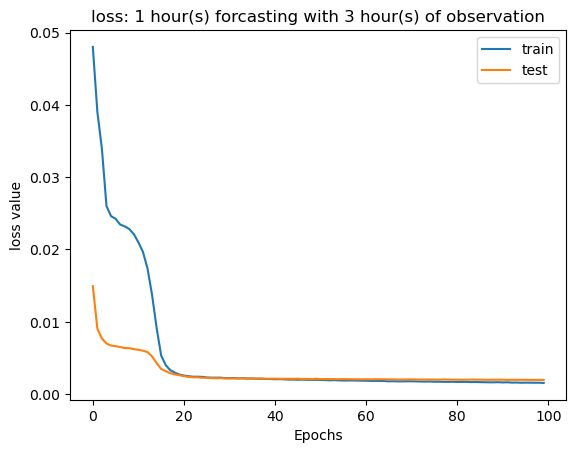

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('Epochs')
plt.ylabel('loss value')
plt.legend()
plt.title('loss: '+str(pre_len)+' hour(s) forcasting ' + 'with ' + str(seq_len) + ' hour(s) of observation', fontsize=12)
plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/loss.png', bbox_inches='tight', dpi=1000)

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

#define weighted_mean_absolute_percentage_error and other eveluation metrics
def weighted_mean_absolute_percentage_error(Y_true, Y_pred):
	total_sum=np.sum(Y_true)
	average=[]
	for i in range(len(Y_true)):
		for j in range(len(Y_true[0])):
			if Y_true[i][j]>0:
				temp=(Y_true[i][j]/total_sum)*np.abs((Y_true[i][j] - Y_pred[i][j]) / Y_true[i][j])
				average.append(temp)
	return np.sum(average)

def evaluate_performance(Y_test_original,predictions):
	RMSE = sqrt(mean_squared_error(Y_test_original, predictions))
	print('RMSE is:  '+str(RMSE))
	MAE=mean_absolute_error(Y_test_original, predictions)
	print("MAE is： "+str(MAE))
	MSE=mean_squared_error(Y_test_original, predictions)
	print("MSE is： "+str(MSE))
	R2 = r2_score(Y_test_original, predictions)
	print("R2 is： "+str(R2))
	WMAPE=weighted_mean_absolute_percentage_error(Y_test_original, predictions)
	print("WMAPE is:  "+str(WMAPE))
	return RMSE, MAE, MSE, R2, WMAPE

In [ ]:
#### make a prediction   for 1 hour

# Chanel = 0

def inv_MaxMinScaler(scale_dict, scaled_values, num_var):
    
    max_val, min_val = scale_dict[str(num_var)]
    inv_y = scaled_values*(max_val - min_val) + min_val
    return inv_y
    
def inv_y (yhat, num_var):
    
    inv_yhat = np.empty([yhat.shape[0], yhat.shape[1]])

    for i in range(yhat.shape[1]):  
        
        inv_yhat[:, i] = inv_MaxMinScaler(dict_scaler[i], yhat[:, i], num_var)
    
        
    return inv_yhat

In [ ]:
dict_scaler = [dict_scaler0, dict_scaler1, dict_scaler2, dict_scaler3]


In [ ]:
#### make a prediction   for 1 hour

# Chanel = 0

def inv_MaxMinScaler(scale_dict, scaled_values, num_var):
    
    max_val, min_val = scale_dict[str(num_var)]
    inv_y = scaled_values*(max_val - min_val) + min_val
    return inv_y
    
def inv_y_multi(yhat, num_var):
    
    inv_yhat = np.empty([yhat.shape[0], yhat.shape[1], yhat.shape[2]])

    for i in range(yhat.shape[1]):
        
        for j in range(yhat.shape[2]):
                        
            inv_yhat[:, i, j] = inv_MaxMinScaler(dict_scaler[i], yhat[:, i, j], num_var)
    
        
    return inv_yhat

In [113]:
y_test_prd = model.predict(testX)
y_test_prd = y_test_prd.reshape(y_test_prd.shape[0], y_test_prd.shape[1], 1)
y_test_prd = inv_y_multi(y_test_prd, target_out)
y_test_true = inv_y_multi(testY, target_out)

77/77 [==============================] - 0s 2ms/step


In [114]:
y_test_prd_zero = model.predict(zero_testX)
y_test_prd_zero = y_test_prd_zero.reshape(y_test_prd.shape[0], y_test_prd.shape[1], 1)
y_test_prd_zero = inv_y_multi(y_test_prd_zero, target_out)
y_test_true_zero = inv_y_multi(testY_zero, target_out)

77/77 [==============================] - 0s 2ms/step


In [115]:
y_train_prd = model.predict(trainX)
y_train_prd = y_train_prd.reshape(y_train_prd.shape[0], y_train_prd.shape[1], 1)

y_train_prd = inv_y_multi(y_train_prd, target_out)
y_train_true = inv_y_multi(trainY, target_out)

y_train_true.shape, y_train_prd.shape

199/199 [==============================] - 0s 2ms/step


((6360, 4, 1), (6360, 4, 1))

In [116]:
# Evaluate performance  (train)
RMSE = []
MAE = []
MSE = []
R2 = []
WMAPE = []
accuracy =[]

for i in range(y_train_true.shape[1]):
        
    rmse, mae, mse, r2, wmape = evaluate_performance(y_train_true[:, i, :], y_train_prd[:, i, :])
    
    
    
    RMSE.append(rmse)
    MAE.append(mae)
    MSE.append(mse)
    R2.append(r2)
    WMAPE.append(wmape)
#     accuracy.append(acc)
print("**********************************")    
print('RMSE: '+ str(np.mean(RMSE)))
print('MAE: '+ str(np.mean(MAE)))
print('MSE: '+ str(np.mean(MSE)))
print('R2: '+ str(np.mean(R2)))
print('WMAPE: '+ str(np.mean(WMAPE)))
# print('WMAPE: '+ str(np.mean(accuracy)))

RMSE is:  1.8251631014572933
MAE is： 1.255151700675972
MSE is： 3.331220346921206
R2 is： 0.9547271432312672
WMAPE is:  0.15389135400631218
RMSE is:  1.4842036220603332
MAE is： 0.8946544441293719
MSE is： 2.2028603917370124
R2 is： 0.9482061441865072
WMAPE is:  0.16296356907172507
RMSE is:  1.2084421192725523
MAE is： 0.8039723527840206
MSE is： 1.4603323556319374
R2 is： 0.9498710839878379
WMAPE is:  0.1658686402027611
RMSE is:  2.019707510893049
MAE is： 1.313093565394779
MSE is： 4.0792184295577965
R2 is： 0.9549954023426259
WMAPE is:  0.1512943422753243
**********************************
RMSE: 1.634379088420807
MAE: 1.0667180157460359
MSE: 2.768407880961988
R2: 0.9519499434370595
WMAPE: 0.15850447638903065


In [117]:
# Evaluate performance  (test)
RMSE = []
MAE = []
MSE = []
R2 = []
WMAPE = []

for i in range(y_test_true.shape[1]):
    print(i)
    
    if i==3:
        
        y_true = y_test_true[0:600, i, :]
        y_prd = y_test_prd[0:600, i, :] 
    
        rmse, mae, mse, r2, wmape = evaluate_performance(y_true, y_prd)
        
    else:
        
        y_true = y_test_true[:, i, :]
        y_prd = y_test_prd[:, i, :] 
    
        rmse, mae, mse, r2, wmape = evaluate_performance(y_true, y_prd)
        
        
    
    RMSE.append(rmse)
    MAE.append(mae)
    MSE.append(mse)
    R2.append(r2)
    WMAPE.append(wmape)
print("**********************************")    
print('RMSE: '+ str(np.mean(RMSE)))
print('MAE: '+ str(np.mean(MAE)))
print('MSE: '+ str(np.mean(MSE)))
print('R2: '+ str(np.mean(R2)))
print('WMAPE: '+ str(np.mean(WMAPE)))

0
RMSE is:  1.9748134079170052
MAE is： 1.3272685195485598
MSE is： 3.8998879960887765
R2 is： 0.83978398272666
WMAPE is:  0.27835355328862343
1
RMSE is:  0.9819824792009504
MAE is： 0.6419355785257927
MSE is： 0.964289589457645
R2 is： 0.893198376855606
WMAPE is:  0.28306961978459416
2
RMSE is:  1.2316067355946032
MAE is： 0.7692649240843248
MSE is： 1.516855151161995
R2 is： 0.8496611420794113
WMAPE is:  0.2728486041085315
3
RMSE is:  1.790838376842705
MAE is： 1.042288154756055
MSE is： 3.2071020919726143
R2 is： 0.7640485747930742
WMAPE is:  0.3070910296172169
**********************************
RMSE: 1.494810249888816
MAE: 0.945189294228683
MSE: 2.397033707170258
R2: 0.836673019113688
WMAPE: 0.28534070169974146


In [119]:
# Evaluate performance  (test-zero)
RMSE = []
MAE = []
MSE = []
R2 = []
WMAPE = []

for i in range(y_test_prd_zero.shape[1]):
    print(i)
    
    if i==3:
        
        y_prd = y_test_prd_zero[0:600, i, :]
        y_true = y_test_true_zero[0:600, i, :] 
    
        rmse, mae, mse, r2, wmape = evaluate_performance(y_true, y_prd)
        
    else:
        
        y_prd = y_test_prd_zero[:, i, :]
        y_true = y_test_true_zero[:, i, :] 
    
        rmse, mae, mse, r2, wmape = evaluate_performance(y_true, y_prd)
        
        
    
    RMSE.append(rmse)
    MAE.append(mae)
    MSE.append(mse)
    R2.append(r2)
    WMAPE.append(wmape)
print("**********************************")    
print('RMSE: '+ str(np.mean(RMSE)))
print('MAE: '+ str(np.mean(MAE)))
print('MSE: '+ str(np.mean(MSE)))
print('R2: '+ str(np.mean(R2)))
print('WMAPE: '+ str(np.mean(WMAPE)))

0
RMSE is:  3.273648726992438
MAE is： 2.0848781842251825
MSE is： 10.716775987739208
R2 is： 0.5597311593337733
WMAPE is:  0.43723876684003615
1
RMSE is:  1.683701543739544
MAE is： 0.923526970613492
MSE is： 2.8348508883909234
R2 is： 0.6860210049319664
WMAPE is:  0.4072409088661774
2
RMSE is:  2.2904161986517
MAE is： 1.7191610363782865
MSE is： 5.246006363046103
R2 is： 0.0
WMAPE is:  85.95805374022655
3
RMSE is:  2.0238436851124804
MAE is： 1.3070927247772757
MSE is： 4.095943261769665
R2 is： 0.6986551651722381
WMAPE is:  0.3851108245118386
**********************************
RMSE: 2.3179025386240406
MAE: 1.508664728998559
MSE: 5.723394125236475
R2: 0.48610183235949445
WMAPE: 21.79691106011115


In [120]:
hours = [1, 6, 12, 24, 36] ## PM2.5 

# ## train #################################
RMSE_train = [1.491, 2.337, 3.769, 4.123, 4.980]
MAE_train = [0.870, 1.397, 2.195, 2.595, 2.955]
MSE_train = [2.297, 5.687, 14.863, 27.432, 37.409]
R2_train = [0.959, 0.902, 0.746, 0.532, 0.402]
WMAPE_train = [0.130, 0.209, 0.326, 0.458, 0.544]

# ######## test ##############
RMSE_test = [1.463, 1.763, 2.326, 2.847, 3.263]
MAE_test = [0.857, 1.026, 1.351, 1.566, 1.885]
MSE_test = [2.275, 3.257, 5.626, 8.903, 11.177]
R2_test = [0.852, 0.785, 0.631, 0.427, 0.347]
WMAPE_test = [0.260, 0.313, 0.413, 0.530, 0.605]

# ######## test ############## 0:600
# RMSE_test = [1.292, 1.420, 1.674, 2.047, 2.358]
# MAE_test = [0.717, 0.836, 1.005, 1.302, 1.549]
# MSE_test = [1.807, 2.210, 3.060, 4.485, 5.901]
# R2_test = [0.769, 0.739, 0.637, 0.471, 0.346]
# WMAPE_test = [0.283, 0.322, 0.391, 0.511, 0.604]

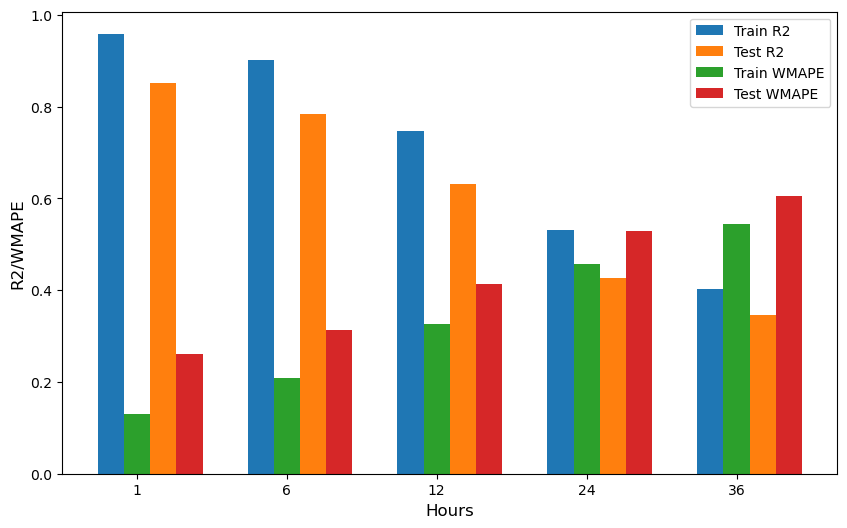

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Data
hours = [1, 6, 12, 24, 36]
metrics = ['RMSE', 'MAE', 'MSE', 'R2', 'WMAPE']

# Train data
RMSE_train = [1.491, 2.337, 3.769, 4.123, 4.980]
MAE_train = [0.870, 1.397, 2.195, 2.595, 2.955]
MSE_train = [2.297, 5.687, 14.863, 27.432, 37.409]
R2_train = [0.959, 0.902, 0.746, 0.532, 0.402]
WMAPE_train = [0.130, 0.209, 0.326, 0.458, 0.544]

# Test data
RMSE_test = [1.463, 1.763, 2.326, 2.847, 3.263]
MAE_test = [0.857, 1.026, 1.351, 1.566, 1.885]
MSE_test = [2.275, 3.257, 5.626, 8.903, 11.177]
R2_test = [0.852, 0.785, 0.631, 0.427, 0.347]
WMAPE_test = [0.260, 0.313, 0.413, 0.530, 0.605]

# Combine data
train_data = [RMSE_train, MAE_train, R2_train, WMAPE_train]
test_data = [RMSE_test, MAE_test, R2_test, WMAPE_test]

# Set up the bar chart
x = np.arange(len(hours))
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
save_path = '/Users/maryamrahmani/Desktop/Thesis/paper/stModel'

# First group of metrics: RMSE, MAE, MSE
# for i, metric in enumerate(['RMSE', 'MAE']):
#     plt.bar(x - width/2 + i * width/2, train_data[i], width/2, label=f'Train {metric}')
#     plt.bar(x + width/2 + i * width/2, test_data[i], width/2, label=f'Test {metric}')
    
# plt.xlabel('Hours', fontsize=12)
# plt.ylabel('RMSE/MAE', fontsize=12)
# # plt.title('RMSE, MAE by Hour')
# plt.xticks(x, hours)
# plt.legend()
# plt.savefig(os.path.join(save_path, 'metrics1.png'), dpi=1000)
# plt.show()


# # Second group of metrics: R2, WMAPE

for i, metric in enumerate(['R2', 'WMAPE']):
    plt.bar(x - width/2 + i * width/2, train_data[i+2], width/2, label=f'Train {metric}')
    plt.bar(x + width/2 + i * width/2, test_data[i+2], width/2, label=f'Test {metric}')
    
plt.xlabel('Hours', fontsize=12)
plt.ylabel('R2/WMAPE', fontsize=12)
# plt.title('R2, WMAPE by Hour')
plt.xticks(x, hours)
plt.legend()
plt.savefig(os.path.join(save_path, 'metrics2.png'), dpi=1000)
plt.show()



In [122]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Data
hours = [1, 6, 12, 24, 36]
metrics = ['RMSE', 'MAE', 'R2', 'WMAPE']

# # Train data
# RMSE_train = [1.491, 2.337, 3.769, 4.123, 4.980]
# MAE_train = [0.870, 1.397, 2.195, 2.595, 2.955]
# MSE_train = [2.297, 5.687, 14.863, 27.432, 37.409]
# R2_train = [0.959, 0.902, 0.746, 0.532, 0.402]
# WMAPE_train = [0.130, 0.209, 0.326, 0.458, 0.544]

# # Test data
# RMSE_test = [1.463, 1.763, 2.326, 2.847, 3.263]
# MAE_test = [0.857, 1.026, 1.351, 1.566, 1.885]
# MSE_test = [2.275, 3.257, 5.626, 8.903, 11.177]
# R2_test = [0.852, 0.785, 0.631, 0.427, 0.347]
# WMAPE_test = [0.260, 0.313, 0.413, 0.530, 0.605]

# Train data
RMSE_train = [1.491, 2.337, 3.769, 4.123, 4.980]
MAE_train = [0.870, 1.397, 2.195, 2.595, 2.955]
MSE_train = [2.297, 5.687, 14.863, 27.432, 37.409]
R2_train = [0.959, 0.902, 0.746, 0.532, 0.402]
WMAPE_train = [0.130, 0.209, 0.326, 0.458, 0.544]

# Test data
RMSE_test = [1.463, 1.763, 2.326, 2.847, 3.263]
MAE_test = [0.857, 1.026, 1.351, 1.566, 1.885]
MSE_test = [2.275, 3.257, 5.626, 8.903, 11.177]
R2_test = [0.852, 0.785, 0.631, 0.427, 0.347]
WMAPE_test = [0.260, 0.313, 0.413, 0.530, 0.605]

# Combine data for easier access
train_data = [RMSE_train, MAE_train, R2_train, WMAPE_train]
test_data = [RMSE_test, MAE_test, R2_test, WMAPE_test]

# Set up the bar chart
x = np.arange(len(hours))  # the label locations
width = 0.35  # width of the bars
save_path = '/Users/maryamrahmani/Desktop/Thesis/paper/stModel'

# # Create the first figure for RMSE and MAE
# fig1, ax1 = plt.subplots(figsize=(10, 6))
# for i, metric in enumerate(['RMSE', 'MAE']):
#     ax1.bar(x - width/2 + i * width, train_data[i], width, label=f'Train {metric}')
#     ax1.bar(x + width/2 + i * width, test_data[i], width, label=f'Test {metric}')
# ax1.set_xlabel('Hours')
# ax1.set_ylabel('Value')
# ax1.set_title('RMSE and MAE by Hour')
# ax1.set_xticks(x)
# ax1.set_xticklabels(hours)
# ax1.legend()
# fig1.tight_layout()
# fig1.savefig(os.path.join(save_path, 'RMSE_MAE_by_Hour.png'))
# plt.show

# Create the second figure for MSE, R2, and WMAPE
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(['R2', 'WMAPE']):
    ax2.bar(x - width/2 + i * width, train_data[i + 2], width, label=f'Train {metric}')
    ax2.bar(x + width/2 + i * width, test_data[i + 2], width, label=f'Test {metric}')
ax2.set_xlabel('Hours')
ax2.set_ylabel('Value')
ax2.set_title('MSE, R2, and WMAPE by Hour')
ax2.set_xticks(x)
ax2.set_xticklabels(hours)
ax2.legend()
fig2.tight_layout()
fig2.savefig(os.path.join(save_path, 'R2_WMAPE_by_Hour.png'))
plt.close(fig2)


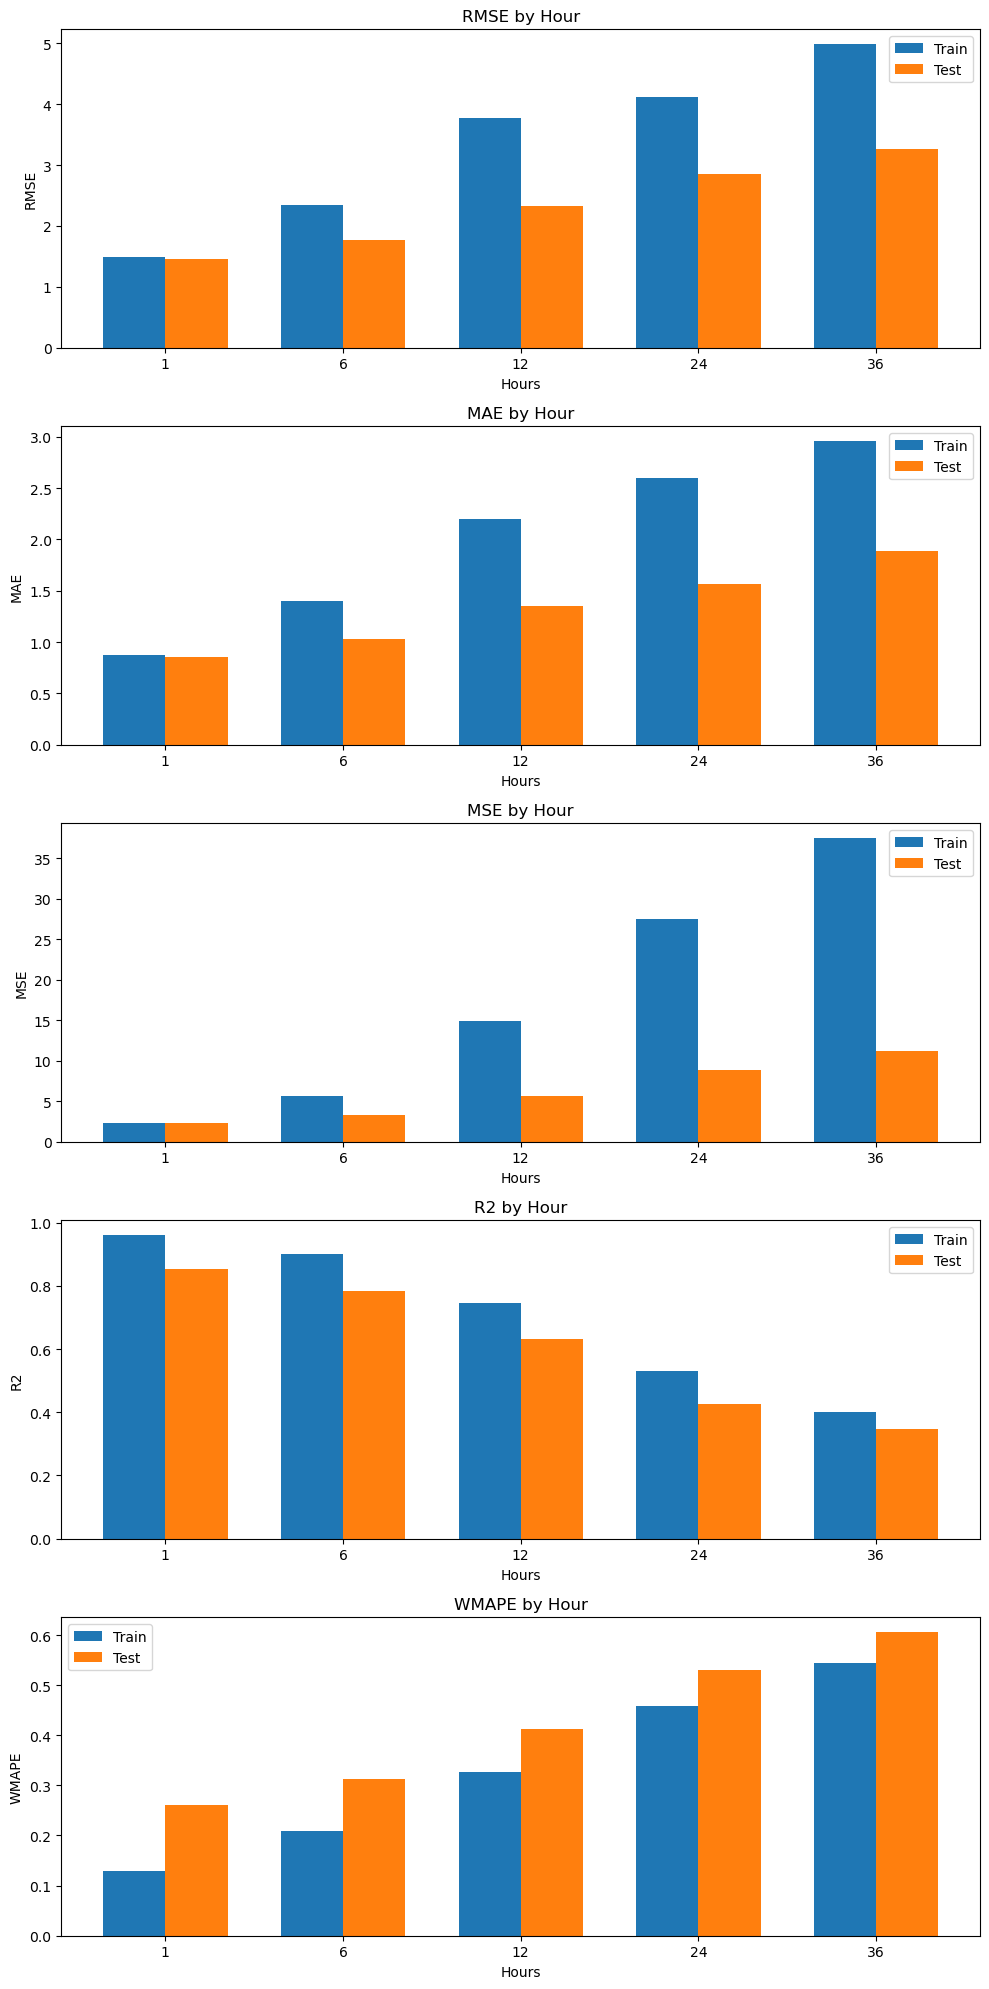

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Data
hours = [1, 6, 12, 24, 36]
metrics = ['RMSE', 'MAE', 'MSE', 'R2', 'WMAPE']

# Train data
RMSE_train = [1.491, 2.337, 3.769, 4.123, 4.980]
MAE_train = [0.870, 1.397, 2.195, 2.595, 2.955]
MSE_train = [2.297, 5.687, 14.863, 27.432, 37.409]
R2_train = [0.959, 0.902, 0.746, 0.532, 0.402]
WMAPE_train = [0.130, 0.209, 0.326, 0.458, 0.544]

# Test data
RMSE_test = [1.463, 1.763, 2.326, 2.847, 3.263]
MAE_test = [0.857, 1.026, 1.351, 1.566, 1.885]
MSE_test = [2.275, 3.257, 5.626, 8.903, 11.177]
R2_test = [0.852, 0.785, 0.631, 0.427, 0.347]
WMAPE_test = [0.260, 0.313, 0.413, 0.530, 0.605]

# Combine data
train_data = [RMSE_train, MAE_train, MSE_train, R2_train, WMAPE_train]
test_data = [RMSE_test, MAE_test, MSE_test, R2_test, WMAPE_test]

# Set up the bar chart
x = np.arange(len(hours))
width = 0.35  # width of the bars

save_path = '/Users/maryamrahmani/Desktop/Thesis/paper/stModel'


fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for i, ax in enumerate(axs):
    ax.bar(x - width/2, train_data[i], width, label='Train')
    ax.bar(x + width/2, test_data[i], width, label='Test')
    ax.set_xlabel('Hours')
    ax.set_ylabel(metrics[i])
    ax.set_title(f'{metrics[i]} by Hour')
    ax.set_xticks(x)
    ax.set_xticklabels(hours)
    ax.legend()

    fig.tight_layout()
    plt.savefig(os.path.join(save_path, f'{metrics[i]}_by_Hour.png'))
    
plt.show()


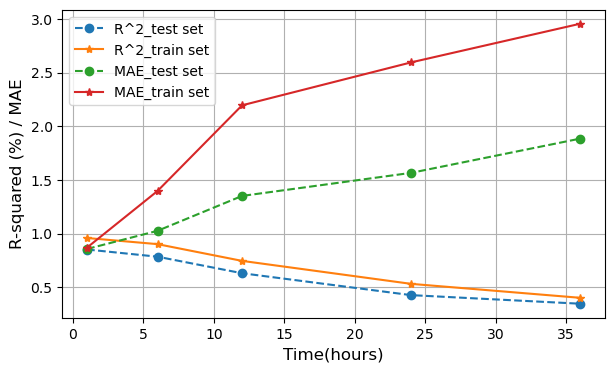

In [124]:
fig, ax = plt.subplots(figsize=(7, 4))

labels= ['R^2_test set', 'R^2_train set', 'MAE_test set', 'MAE_train set']

colors = ['red', 'blue', 'green', 'black']


ax.plot(hours, R2_test, label='_test set', marker='o', linestyle='--')
ax.plot(hours, R2_train, label='_train set', marker='*', linestyle='-')

ax.plot(hours, MAE_test, label='_test set', marker='o', linestyle='--')
ax.plot(hours, MAE_train, label='_train set', marker='*', linestyle='-')


ax.set_xlabel('Time(hours)', fontsize=12)
ax.set_ylabel('R-squared (%) / MAE', fontsize=12)
# ax.set_title('Temporal Analysis of RMSE in Long-Term PM2.5 Forecasting (hour)')

ax.grid(True)
ax.legend(labels)
plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/HRplot-longterm.jpg', bbox_inches='tight', dpi=1000)



In [125]:
Title_str = "PM2.5"
Site_str = "Canal: "
site_num = 0

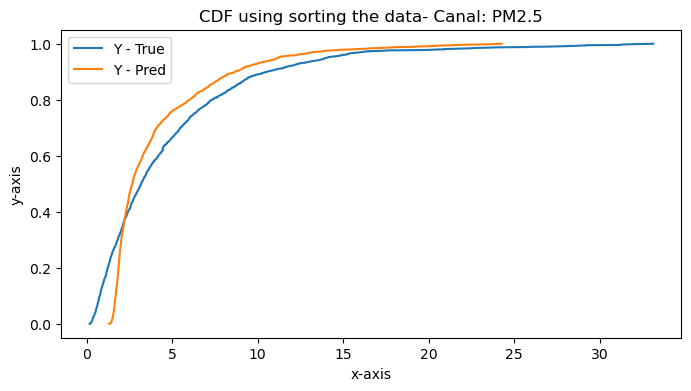

In [126]:
##### CDF

plt.subplots(figsize=(8, 4))
  
# plotting
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('CDF using sorting the data- '+Site_str+Title_str)

x = np.sort(y_test_true[:,site_num, 0])
y = np.arange(len(y_test_true[:,site_num, 0])) / float(len(y_test_true[:,site_num]))
plt.plot(x, y, label='Y - True')
plt.legend() 


x = np.sort(y_test_prd[:,site_num, 0])
y = np.arange(len(y_test_prd[:,site_num, 0])) / float(len(y_test_prd[:,site_num]))
plt.plot(x, y, label="Y - Pred")
plt.legend()

plt.show()


In [127]:
# timeseris_plot(df_0, seq_len, n_train, y_train_true, y_train_prd, y_test_true, 
#                 y_test_prd, 0, title='PM2.5_12SW(Canal)'
#               )

In [128]:
def Mtimeseris_plot2(df, pre_len, seq_len, n_train, y_train, y_hat_train, y_test, y_hat_test,
                    num_site, title):
    
    plt.subplots(figsize=(7, 3))

    x_ = df.index[seq_len:n_train + pre_len + seq_len]
    data_ = df[seq_len:n_train + pre_len + seq_len]  ##[pre_len+n_train_hours:]
    y_hat_ = y_hat_train[:, num_site, :]  ### train
    y_ = y_train[:, num_site, :]

    for i in range(pre_len):
        
        x_i = x_[i:n_train+i]
        data_i = data_[i:n_train+i]
        
        fig1 = sns.lineplot(x=x_i, y=y_hat_[:, i], data=data_i, legend='brief', color="salmon", size=7)
        fig2 = sns.lineplot(x=x_i, y=y_[:, i], data=data_i, legend='brief', color="tab:blue", linestyle="dotted", size=7)

    prd_train = mpatches.Patch(color='salmon', label='Train_pred')
    true_train = mpatches.Patch(color='tab:blue', label='Train_true')
    
    plt.axvline(x=x_[n_train], color='Green', linestyle='--', label='Training Boundary')


    x = df.index[seq_len+n_train:]
    data = df[seq_len+n_train:]
    y_hat = y_hat_test[:, num_site, :]  ### test
    y = y_test[:, num_site, :]
    
    for i in range(pre_len):
        
        if i==pre_len-1:
            x_i = x[i:]
            data_i = data[i:]
            
        else:
            x_i = x[i:-(pre_len-i-1)]
            data_i = x[i:-(pre_len-i-1)]
                               
        sns.lineplot(x=x_i, y=y_hat[:, i], data=data_i, legend='brief', color="goldenrod", size=7)
        sns.lineplot(x=x_i, y=y[:, i], data=data_i, legend='brief', color="teal", linestyle="dashed", size=7)

    prd_test = mpatches.Patch(color='goldenrod', label='Test_pred')
    true_test = mpatches.Patch(color='teal', label='Test_true')

    plt.xticks(rotation=65, horizontalalignment='right', size=8)
    plt.yticks(rotation=0, horizontalalignment='right', size=8)
    
    legend_l = ['train_pred', 'train_true', 'test_pred', 'test_true']

    # plt.xticks(ticks=x_num, labels=x_label , size=14, rotation=45) if len(x_num)!=0 else None
    plt.legend(handles=[prd_train, true_train, prd_test, true_test], bbox_to_anchor=(0.81, 1), loc='upper left',
               borderaxespad=0, fontsize=8)
#     plt.title(title + str(pre_len) +' hour(s) Forecasting with ' + str(seq_len) +' hour(s) of Observation', fontsize=11)
#     plt.title(title)
    plt.ylabel(ylabel="PM2.5 (μg/ m^3)", fontsize=10)
    plt.xlabel(xlabel="(c) Janin", fontsize=10)

#     name = title + str(seq_len) + ' F-' + str(pre_len) + 'O.png'
#     file_path = os.path.join(path, name)
    plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/Janin.png', bbox_inches='tight', dpi=1000)
    
    plt.show()

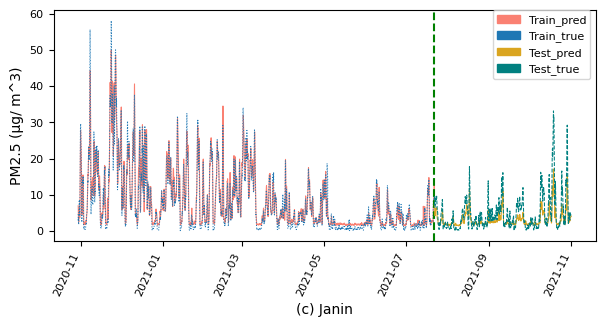

In [129]:
Mtimeseris_plot2(df_0, pre_len, seq_len, n_train, y_train_true, y_train_prd,
                 y_test_true_zero, y_test_prd_zero, 0, title='Forecasting PM2.5 for Canal Station')

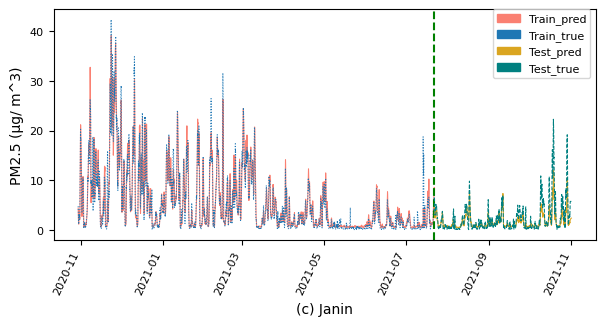

In [130]:
Mtimeseris_plot2(df_1, pre_len, seq_len, n_train, y_train_true, y_train_prd,
                 y_test_true_zero, y_test_prd_zero, 1, title='Forecasting PM2.5 for Hoche Station')

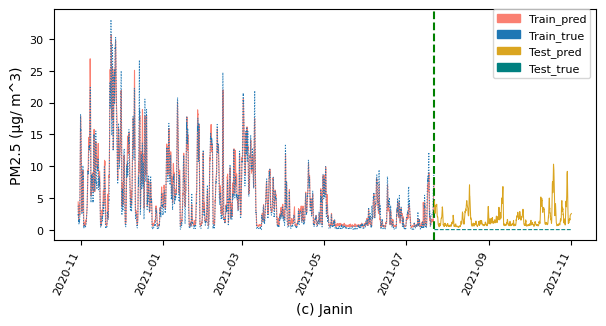

In [131]:
Mtimeseris_plot2(df_2, pre_len, seq_len, n_train, y_train_true, y_train_prd,
                 y_test_true_zero, y_test_prd_zero, 2, title='Forecasting PM2.5 for Carnot Station')

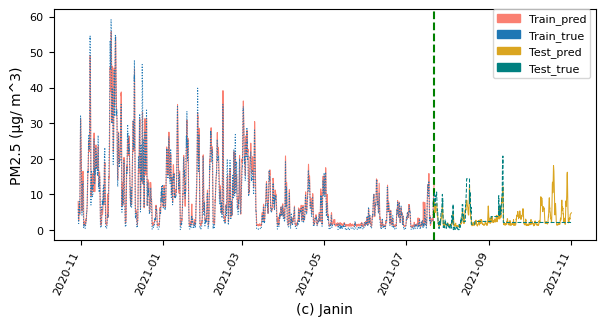

In [132]:
Mtimeseris_plot2(df_3, pre_len, seq_len, n_train, y_train_true, y_train_prd,
                 y_test_true_zero, y_test_prd_zero, 3, title='Forecasting PM2.5 for Janin Station')

In [133]:
df_3[6720:]

,PM1_SW12,PM25_SW12,PM10_SW12,Temp_SW12,RH_SW12,hour,day_of_week
Timestamp,,,,,,,
2021-08-05 23:00:00,0.28375,0.472778,0.590833,17.665277,99.650002,23.0,3.0
2021-08-06 00:00:00,0.27200,0.486667,0.637857,17.838335,99.623817,0.0,4.0
2021-08-06 01:00:00,0.23500,0.442500,0.610208,18.113958,99.133331,1.0,4.0
2021-08-06 02:00:00,0.23500,0.442500,0.580185,18.399630,98.674080,2.0,4.0
2021-08-06 03:00:00,0.23500,0.442500,0.590167,18.744165,98.046669,3.0,4.0
...,...,...,...,...,...,...,...
2021-10-31 20:00:00,0.73000,2.030000,2.500000,25.809999,99.000000,20.0,6.0
2021-10-31 21:00:00,0.73000,2.030000,2.500000,25.809999,99.000000,21.0,6.0
2021-10-31 22:00:00,0.73000,2.030000,2.500000,25.809999,99.000000,22.0,6.0


In [134]:
### plot for test zero

def timeseris_plot4(df, pre_len, seq_len, y_test_true, y_test_prd, y_test_true_zero, y_test_prd_zero, title):
    
    plt.subplots(figsize=(7, 3))

    starting_point = 6360
    x = df.index[seq_len+starting_point:]
    data = df[seq_len+starting_point:]
    
                   
    sns.lineplot(x=x, y=y_test_true[: , 2, 0], data=data, legend='brief', label='y_test_true', color="blue", linestyle="dotted")
    sns.lineplot(x=x, y=y_test_prd[: , 2, 0], data=data, legend='brief', color="red", label='y_test_pred')
    sns.lineplot(x=x, y=y_test_true_zero[: , 2, 0], data=data, legend='brief', label='y_test_true_zero', color="orange", linestyle="--")
    sns.lineplot(x=x, y=y_test_prd_zero[: , 2, 0], data=data, legend='brief', label='y_test_pred_zero', color="green")

    
    plt.xticks(rotation=65, horizontalalignment='right', size=8)
    plt.yticks(rotation=0, horizontalalignment='right', size=8)

    legend_l = ['test_true', 'test_pred', 'test_zero']

    plt.ylabel(ylabel="PM2.5 (μg/ m^3)", fontsize=9)
    plt.xlabel(xlabel="timestamp", fontsize=9)

    plt.grid(True)
    plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/zero-plot.png', bbox_inches='tight', dpi=1000)

    
    plt.show()
    

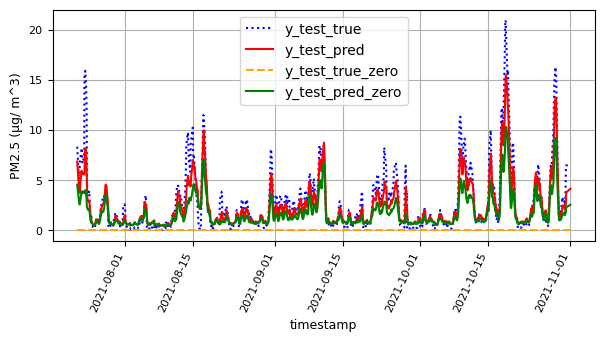

In [135]:
timeseris_plot4(df_2, pre_len, seq_len, y_test_true, y_test_prd, y_test_true_zero, y_test_prd_zero, title='Forecasting PM2.5 for Hoche Station')

In [136]:
def timeseris_plot5(df, pre_len, seq_len, y_test_true, y_test_prd, y_test_true_zero, y_test_prd_zero, title):
    fig, axes = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [3, 1]})

    starting_point = 6360
    x = df.index[seq_len+starting_point:]
    data = df[seq_len+starting_point:]
    
    # Line plot
    sns.lineplot(ax=axes[0], x=x, y=y_test_true[:, 2, 0], data=data, legend='brief', label='y_true', color="blue", linestyle="dotted")
    sns.lineplot(ax=axes[0], x=x, y=y_test_prd[:, 2, 0], data=data, legend='brief', label='y_pred', color="red")
    sns.lineplot(ax=axes[0], x=x, y=y_test_prd_zero[:, 2, 0], data=data, legend='brief', label='y_pred_zero', color="green")
    sns.lineplot(ax=axes[0], x=x, y=y_test_true_zero[:, 2, 0], data=data, legend='brief', label='y_true_zero', color="orange", linestyle="--")

    axes[0].set_xticks(x[::int(len(x)/10)])  # Reduce the number of x-ticks
    axes[0].tick_params(axis='x', rotation=65, labelsize=8)
    axes[0].tick_params(axis='y', rotation=0, labelsize=8)
    axes[0].set_ylabel("PM2.5 (μg/ m^3)", fontsize=9)
    axes[0].set_xlabel("Timestamp", fontsize=9)
    axes[0].grid(True)
    axes[0].legend()
#     axes[0].set_title(title)

    # Box plot
    box_data = pd.DataFrame({
        'y_true': y_test_true[:, 2, 0],
        'y_pred': y_test_prd[:, 2, 0],
        'y_pred_zero': y_test_prd_zero[:, 2, 0],
        'y_true_zero': y_test_true_zero[:, 2, 0],
    })

    sns.boxplot(data=box_data, ax=axes[1])
#     axes[1].set_ylabel("PM2.5 (μg/ m^3)", fontsize=9)
    axes[1].set_xlabel("Metrics", fontsize=9)
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)
#     axes[1].tick_params(axis='y', rotation=0, labelsize=8)

    plt.tight_layout()
    plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/zero-BoxPlot.png', bbox_inches='tight', dpi=1000)
    plt.show()

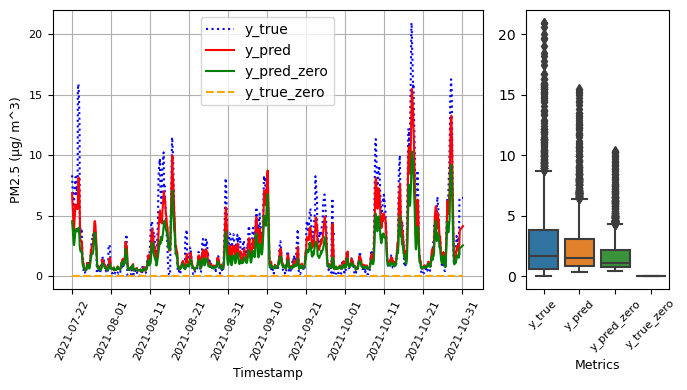

In [137]:
timeseris_plot5(df_2, pre_len, seq_len, y_test_true, y_test_prd, y_test_true_zero, y_test_prd_zero, title='Forecasting PM2.5 for Hoche Station')

In [138]:
evaluate_performance(y_test_prd[:, 2], y_test_prd_zero[:, 2])

RMSE is:  1.0649734241304551
MAE is： 0.6643619334083896
MSE is： 1.1341683941041465
R2 is： 0.78728410866855
WMAPE is:  0.27658675710252134


(1.0649734241304551,
 0.6643619334083896,
 1.1341683941041465,
 0.78728410866855,
 0.27658675710252134)

Text(0, 0.5, 'true')

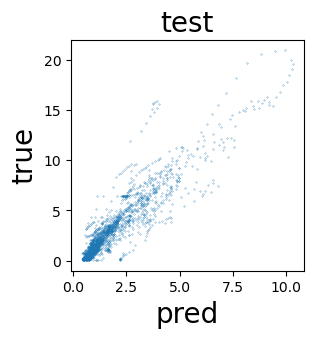

In [139]:
plt.subplots(figsize=(3, 3))

plt.scatter(y_test_prd_zero[:, 2, :], y_test_true[:, 2], marker=".", s=0.2)  ## [:, 0:3, :]
plt.title("test", fontsize=20)
plt.xlabel('pred', fontsize=20)
plt.ylabel('true', fontsize=20)

(array([1565.,  384.,  227.,  117.,   66.,   36.,   15.,   13.,   14.,
          10.]),
 array([ 1.30261552,  3.5991032 ,  5.89559088,  8.19207855, 10.48856623,
        12.78505391, 15.08154159, 17.37802926, 19.67451694, 21.97100462,
        24.26749229]),
 <BarContainer object of 10 artists>)

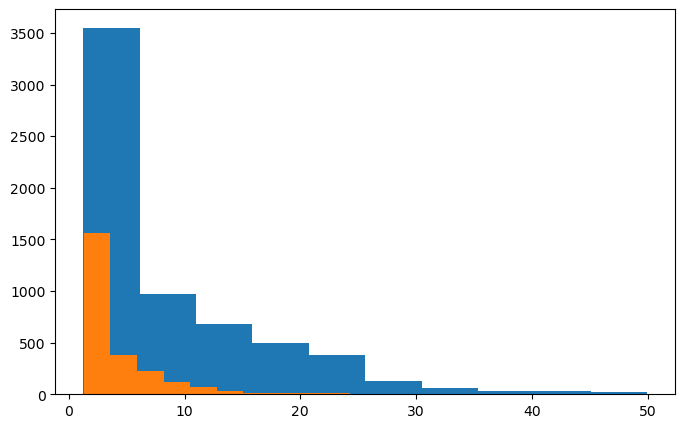

In [140]:
plt.subplots(figsize=(8, 5))
plt.hist(y_train_prd[:, 0, :])
plt.hist(y_test_prd[:, 0, :])

In [141]:
y_test_true.shape

(2447, 4, 1)

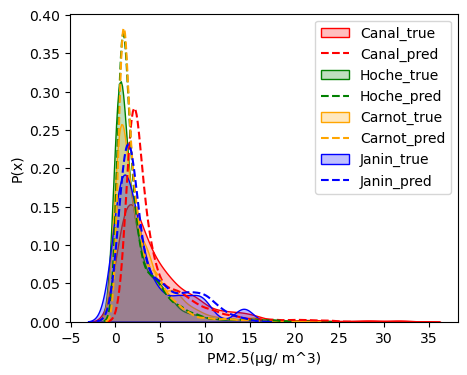

In [142]:
plt.subplots(figsize=(5, 4))
color = ['red', 'green', 'orange', 'blue']

for i in range(y_test_true.shape[1]):
    
    
    if i==3:
        
        y_true = y_test_true[0:600, i, 0]
        y_prd = y_test_prd[0:600, i, 0] 
    
        sns.kdeplot(y_true, fill=True, label='true', color=color[i])   ## log normal
        sns.kdeplot(y_prd, linestyle='dashed', label='pred', color=color[i])

        
    else:
        
        y_true = y_test_true[:, i, 0]
        y_prd = y_test_prd[:, i, 0] 
    
        sns.kdeplot(y_true, fill=True, label='true', color=color[i])   ## log normal
        sns.kdeplot(y_prd, linestyle='dashed', label='pred', color=color[i])        
        
plt.xlabel('PM2.5(μg/ m^3)')
plt.ylabel('P(x)')
plt.legend(['Canal_true', 'Canal_pred', 'Hoche_true', 'Hoche_pred', 
            'Carnot_true', 'Carnot_pred', 'Janin_true', 'Janin_pred'])
plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/G_all.png', bbox_inches='tight', dpi=1000)

plt.show()

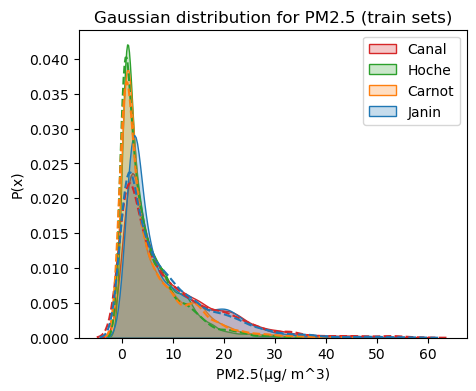

In [143]:
plt.subplots(figsize=(5, 4))

sns.kdeplot(y_train_prd[:, :, 0], fill=True, label='pred')   ## log normal

plt.title('Gaussian distribution for PM2.5 (train sets)')
plt.xlabel('PM2.5(μg/ m^3)')
plt.ylabel('P(x)')


sns.kdeplot(y_train_true[:, :, 0], linestyle='dashed', label='true')   ## log normal
plt.xlabel('PM2.5(μg/ m^3)')
plt.ylabel('P(x)')
plt.legend(['Canal', 'Hoche', 'Carnot', 'Janin'])
plt.show()

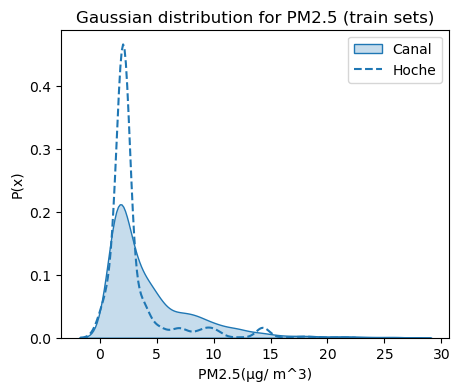

In [144]:
plt.subplots(figsize=(5, 4))

sns.kdeplot(y_test_prd[:, 3, 0], fill=True, label='pred')   ## log normal

plt.title('Gaussian distribution for PM2.5 (train sets)')
plt.xlabel('PM2.5(μg/ m^3)')
plt.ylabel('P(x)')


sns.kdeplot(y_test_true[:, 3, 0], linestyle='dashed', label='true')   ## log normal
plt.xlabel('PM2.5(μg/ m^3)')
plt.ylabel('P(x)')
plt.legend(['Canal', 'Hoche', 'Carnot', 'Janin'])
plt.show()

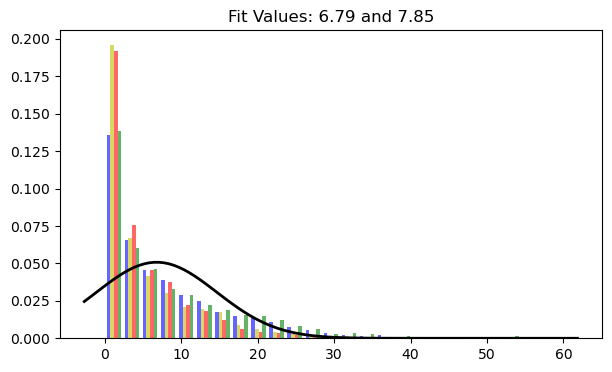

In [145]:
from scipy.stats import norm
  
# Generate some data for this 
# demonstration.  
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(y_train_true[:, :, 0]) 
plt.subplots(figsize=(7, 4))
  
# Plot the histogram.
plt.hist(y_train_true[:, :, 0], bins=25, density=True, alpha=0.6, color=['b', 'y', 'r', 'g'])
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

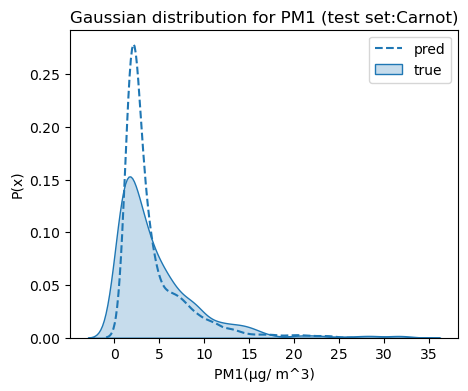

In [146]:
plt.subplots(figsize=(5, 4))


sns.kdeplot(y_test_prd[:, 0, 0], linestyle='dashed', label='pred')   ## log normal

plt.title('Gaussian distribution for PM1 (test set:Carnot)')
plt.xlabel('PM1(μg/ m^3)')
plt.ylabel('P(x)')
plt.legend()

sns.kdeplot(y_test_true[:, 0, 0], fill=True, label='true')   ## log normal
plt.xlabel('PM1(μg/ m^3)')
plt.ylabel('P(x)')
plt.legend()
plt.show()

In [149]:
def Mtimeseris_plot(df, pre_len, seq_len, n_train, y_train, y_hat_train, y_test, y_hat_test,
                    num_station, title):
    
    plt.subplots(figsize=(20, 8))

    x_ = df.index[pre_len:n_train + pre_len + seq_len]
    data_ = df[pre_len:n_train + pre_len + seq_len]  ##[pre_len+n_train_hours:]
    y_hat_ = y_hat_train[:, num_station]  ### train
    y_ = y_train[:, num_station]

    for i in range(seq_len):
        
        x_i = x_[i:n_train+i]
        data_i = data_[i:n_train+i]
        
        fig1 = sns.lineplot(x=x_i, y=y_hat_, data=data_i, legend='brief', color="hotpink")
        fig2 = sns.lineplot(x=x_i, y=y_, data=data_i, legend='brief', color="tab:blue", linestyle="dotted")

    prd_train = mpatches.Patch(color='hotpink', label='Ytarin_prd')
    true_train = mpatches.Patch(color='tab:blue', label='Ytarin_true')

    x = df.index[pre_len+n_train:]
    data = df[pre_len+n_train:]
    y_hat = y_hat_test[:, num_station]  ### test
    y = y_test[:, num_station]
    
    print(x.shape)
    print(data.shape)
    print(y_hat.shape)
    
    
    for i in range(seq_len):
        
        if i==seq_len-1:
            x_i = x[i:]
            data_i = data[i:]
        else:
            x_i = x[i:-(seq_len-i-1)]
            data_i = x[i:-(seq_len-i-1)]
        
        sns.lineplot(x=x_i, y=y_hat, data=data_i, legend='brief', color="goldenrod")
        sns.lineplot(x=x_i, y=y, data=data_i, legend='brief', color="teal", linestyle="dashed")

    prd_test = mpatches.Patch(color='goldenrod', label='Ytest_prd')
    true_test = mpatches.Patch(color='teal', label='Ytest_true')

    plt.xticks(rotation=65, horizontalalignment='right')
    # plt.xticks(ticks=x_num, labels=x_label , size=14, rotation=45) if len(x_num)!=0 else None
    plt.legend(handles=[prd_train, true_train, prd_test, true_test], bbox_to_anchor=(1.02, 1), loc='upper left',
               borderaxespad=0)
    plt.title(title + str(seq_len) +' hour(s) Forecasting with ' + str(pre_len) +' hour(s) of Observation', fontsize=20)
    plt.ylabel(ylabel="PM1", fontsize=15)
    plt.xlabel(xlabel="timestamp", fontsize=15)

#     name = title + str(seq_len) + ' F-' + str(pre_len) + 'O.png'
#     file_path = os.path.join(path, name)
#     plt.savefig(file_path)
    
    plt.show()

In [150]:
def timeseris_plot(df, seq_len, n_train_hours, y_train, y_hat_train, y_test, y_hat_test, num_station, title='PM1_12MW(Canal)'):
    
    

    plt.figure(figsize=(20, 8))

    x_ = df.index[seq_len:n_train_hours + seq_len]  
    data_ = df[seq_len:n_train_hours + seq_len]    ##[pre_len+n_train_hours:]
    y_hat_ = y_hat_train[:, num_station]   ### train
    y_ = y_train[:, num_station]
    
    print(data_.shape)
    print(x_.shape)
    
    sns.lineplot(x = x_, y = y_hat_, data = data_, legend='brief', label= 'PM1_prd_train', 
                 color="tab:blue")
    sns.lineplot(x = x_, y = y_, data = data_, legend='brief', label= 'PM1_act_train', 
                 color="salmon", linestyle="dashed")


    x = df.index[n_train_hours + seq_len:]
    data = df[n_train_hours + seq_len:]
    y_hat = y_hat_test[:, num_station]    ### test
    y = y_test[:, num_station]
    sns.lineplot(x = x, y = y_hat, data = data, legend='brief', label= 'PM1_prd_test',
                 color="turquoise")
    sns.lineplot(x = x, y = y, data = data, legend='brief', label= 'PM1_act_test',
                 color="grey", linestyle="dotted")


    plt.xticks(rotation=65, horizontalalignment='right')
    #plt.xticks(ticks=x_num, labels=x_label , size=14, rotation=45) if len(x_num)!=0 else None
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(title, fontsize=40)
    plt.ylabel(ylabel="")

    plt.show()

In [151]:
# unites = [32, 64, 128, 256]   ## 1 layer  for 1 hour forecasting PM1

# ## train #################################
# RMSE_train = [0.774, 0.819, 0.719, 0.743]
# MAE_train = [0.438, 0.410, 0.415, 0.462]
# MSE_train = [0.641, 0.732, 0.552, 0.581]
# R2_train = [0.959, 0.960, 0.964, 0.962]
# WMAPE_train = [0.118, 0.132, 0.111, 0.125]

# ######## test ##############
# RMSE_test = [0.763, 0.736, 0.778, 0.808]
# MAE_test = [0.438, 0.452, 0.447, 0.499] 
# MSE_test = [0.635, 0.594, 0.660, 0.706]
# R2_test = [0.868, 0.877, 0.865, 0.851]
# WMAPE_test = [0.222, 0.231, 0.225, 0.253]


## 64 32
# RMSE: 0.7684541196523419
# MAE: 0.4321359508827826
# MSE: 0.6276254016076616
# R2: 0.960518365702433
# WMAPE: 0.11536806216559076

## 64 32
# RMSE: 0.7408229660598443
# MAE: 0.41924525265065204
# MSE: 0.5938153117133305
# R2: 0.8755290180488303
# WMAPE: 0.21247729118987768

NameError: name 'unites' is not defined

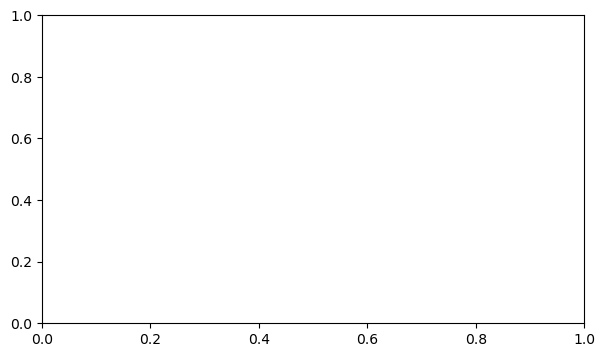

In [152]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(unites, MAE_train, label='MAE-Train', marker='o', linestyle='-')
ax.plot(unites, MAE_test, label='MAE_Test' , marker='o', linestyle='-')

ax.plot(unites, R2_train, label='R2-Train', marker='o', linestyle='-')
ax.plot(unites, R2_test, label='R2_Test' , marker='o', linestyle='-')

ax.set_xticks(unites)

ax.set_xlabel('Unites', fontsize=12)
# ax.set_ylabel(fontsize=12)
ax.set_title('Evaluating Performance Across Different Numbers of Unites')
ax.legend(fontsize=6)
ax.grid(True)

In [153]:
# hours = [1, 6, 12, 24, 48] ## 64 32 unit  for PM1

# ## train #################################
# RMSE_train = [0.768, 1.087, 1.677, 2.463, 3.279]
# MAE_train = [0.432, 0.676, 0.997, 1.502, 2.062]
# MSE_train = [0.627,  1.251, 2.974, 6.417, 11.323]
# R2_train = [0.960, 0.920, 0.812, 0.595, 0.279]
# WMAPE_train = [0.115, 0.181, 0.268, 0.403, 0.555]

# ######## test ##############
# RMSE_test = [0.740, 0.864, 1.177, 1.559, 1.943]
# MAE_test = [0.419, 0.561, 0.724, 0.970, 1.227]
# MSE_test = [0.593, 0.799, 1.503, 2.664, 4.181]
# R2_test = [0.876, 0.827, 0.684, 0.445, 0.119]
# WMAPE_test = [0.212, 0.289, 0.370, 0.498, 0.642]



In [154]:

# layers = [1, 2, 3, 4, 5] ## 64 unit  PM1. for 1hour

# ## train #################################
# RMSE_train = [0.819, 0.780, 0.722, 0.763, 0.768]
# MAE_train = [ 0.498, 0.466, 0.413, 0.451, 0.447]
# MSE_train = [0.732, 0.627, 0.553, 0.610, 0.609]
# R2_train = [0.955, 0.957, 0.964, 0.960, 0.958]
# WMAPE_train = [0.132, 0.125, 0.111, 0.121, 0.122]

# ######## test ##############
# RMSE_test = [0.736, 0.734, 0.752, 0.784, 0.826]
# MAE_test = [0.452, 0.431, 0.433, 0.476, 0.506] 
# MSE_test = [0.594, 0.576, 0.609, 0.663, 0.731]
# R2_test = [0.877, 0.876, 0.870, 0.858, 0.842]
# WMAPE_test = [0.231, 0.219, 0.220, 0.241, 0.257]

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

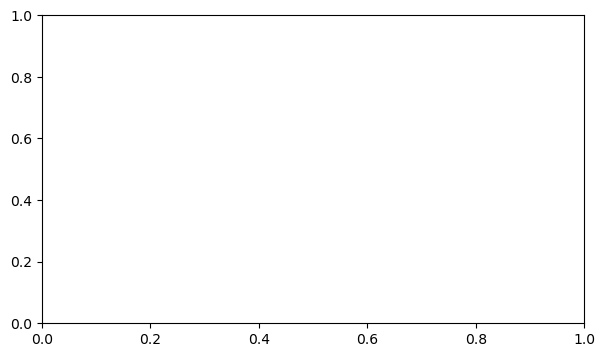

In [155]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(layers, MAE_train, label='MAE-Train', marker='o', linestyle='-')
ax.plot(layers, MAE_test, label='MAE_Test' , marker='o', linestyle='-')

ax.plot(layers, R2_train, label='R2-Train', marker='o', linestyle='-')
ax.plot(layers, R2_test, label='R2_Test' , marker='o', linestyle='-')

ax.set_xticks(layers)
ax.set_xlabel('Number of Layers', fontsize=12)
# ax.set_ylabel(fontsize=12)
# ax.set_title('Evaluating Performance Across Different Numbers of Layers')
ax.legend(fontsize=6)
ax.grid(True)
# ax.minorticks_off()

In [ ]:
# hours = [1, 6, 12, 24, 48] ## 64 32 unit  for PM1

# ## train #################################
# RMSE_train = [0.768, 1.087, 1.677, 2.463, 3.279]
# MAE_train = [0.432, 0.676, 0.997, 1.502, 2.062]
# MSE_train = [0.627,  1.251, 2.974, 6.417, 11.323]
# R2_train = [0.960, 0.920, 0.812, 0.595, 0.279]
# WMAPE_train = [0.115, 0.181, 0.268, 0.403, 0.555]

# ######## test ##############
# RMSE_test = [0.740, 0.864, 1.177, 1.559, 1.943]
# MAE_test = [0.419, 0.561, 0.724, 0.970, 1.227]
# MSE_test = [0.593, 0.799, 1.503, 2.664, 4.181]
# R2_test = [0.876, 0.827, 0.684, 0.485, 0.163]
# WMAPE_test = [0.212, 0.289, 0.370, 0.498, 0.642]

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(hours, RMSE_train, label='RMSE-Train', marker='*', linestyle='-')
ax.plot(hours, RMSE_test, label='RMSE_Test' , marker='*', linestyle='-')

ax.plot(hours, MAE_train, label='MAE-Train', marker='.', linestyle='-')
ax.plot(hours, MAE_test, label='MAE_Test' , marker='.', linestyle='-')

ax.plot(hours, R2_train, label='R2-Train', marker='o', linestyle='-')
ax.plot(hours, R2_test, label='R2_Test' , marker='o', linestyle='-')

ax.set_xticks(hours)
ax.set_xlabel('Time (hours)', fontsize=12)
# ax.set_ylabel(fontsize=12)
ax.set_title('Metric Evaluation for Long-Term PM1 Forecasting')
ax.legend(fontsize=6)
ax.grid(True)
# ax.minorticks_off()

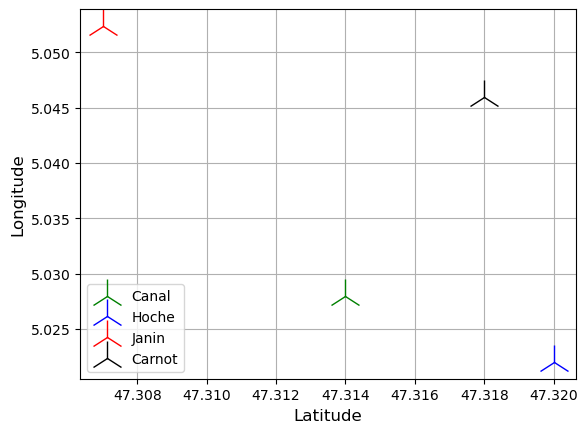

In [156]:
# locations = [[47.314, 5.028], [47.320, 5.022], [47.318, 5.046], [47.307, 5.0524]]

# loc_names = ['node1: Canal', 'node2: Hoche', 'node3: Carnot', 'node4: Janin']

locations = [[47.314, 5.028], [47.320, 5.022], [47.307, 5.0524], [47.318, 5.046]]

loc_names = ['Canal', 'Hoche', 'Janin', 'Carnot']

color = ['green', 'blue', 'red', 'black']

for i in range(len(locations)):
    
    plt.plot(locations[i][0], locations[i][1],  marker='2', markersize=25, color=color[i], linestyle='None')

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.legend(loc_names)
plt.grid()
plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/lat-lon2.png', bbox_inches='tight', transparent=True, dpi=1000)
plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/lat-lon.png', bbox_inches='tight', dpi=1000)

plt.show()

In [161]:
### plot for 2 days 

def timeseris_plot3(df, pre_len, seq_len, n_train, y_train, y_hat_train, y_test, y_hat_test, num_site, title):
    
    plt.subplots(figsize=(7, 3))

#     x_ = df.index[seq_len:n_train + pre_len + seq_len]
#     data_ = df[seq_len:n_train + pre_len + seq_len]  ##[pre_len+n_train_hours:]
#     y_hat_ = y_hat_train  ### train
#     y_ = y_train

#     for i in range(pre_len):
        
#         x_i = x_[i:n_train+i]
#         data_i = data_[i:n_train+i]
        
#         fig1 = sns.lineplot(x=x_i, y=y_hat_[:, i], data=data_i, legend='brief', color="salmon", label='tarin_pred')
#         fig2 = sns.lineplot(x=x_i, y=y_[:, i], data=data_i, legend='brief', color="tab:blue", label='tarin_true', linestyle="dotted")

#     prd_train = mpatches.Patch(color='salmon', label='tarin_pred' )
#     true_train = mpatches.Patch(color='tab:blue', label='tarin_true', linestyle="dotted")

    n_train = 100*24

    starting_point = 0
    x = df.index[seq_len+n_train+starting_point:seq_len+n_train+starting_point+48]
    data = df[seq_len+n_train+starting_point:seq_len+n_train+starting_point+48]
    y_hat = y_hat_test[starting_point:starting_point+48]  ### test
    y = y_test[starting_point:starting_point+48]
    
    
    
    for i in range(pre_len):
        
        if i==pre_len-1:
            x_i = x[i:]
            data_i = data[i:]
            
        else:
            x_i = x[i:-(pre_len-i-1)]
            data_i = x[i:-(pre_len-i-1)] 
                    
#         sns.lineplot(x=x_i, y=y_hat[:, num_site, i], data=data_i, legend='brief', label='Canal_pred', color="blue")
#         sns.lineplot(x=x_i, y=y[:, num_site, i], data=data_i, legend='brief', color="blue", label='Canal_true', linestyle="dotted")

        sns.lineplot(x=x_i, y=y_hat[:, 1, i], data=data_i, legend='brief', label='Hoche_pred', color="blue")
        sns.lineplot(x=x_i, y=y[:, 1, i], data=data_i, legend='brief', color="blue", label='Hoche_true', linestyle="dotted")

        sns.lineplot(x=x_i, y=y_hat[:, 0, i], data=data_i, legend='brief', label='Canal_pred', color="red")
        sns.lineplot(x=x_i, y=y[:, 0, i], data=data_i, legend='brief', color="red", label='Canal_true', linestyle="dotted")
        
#         sns.lineplot(x=x_i, y=y_hat[:, 3, i], data=data_i, legend='brief', label='node3_pred', color="red")
#         sns.lineplot(x=x_i, y=y[:, 3, i], data=data_i, legend='brief', color="red", label='node3_true', linestyle="dotted")

#     prd_test = mpatches.Patch(color='goldenrod', label='test_pred')
#     true_test = mpatches.Patch(color='teal', label='test_true')

    plt.xticks(rotation=65, horizontalalignment='right', size=8)
    plt.yticks(rotation=0, horizontalalignment='right', size=8)

    legend_l = ['test_pred', 'test_true']
    
    # plt.xticks(ticks=x_num, labels=x_label , size=14, rotation=45) if len(x_num)!=0 else None
#     plt.legend(bbox_to_anchor=(0.81, 1), loc='upper left',
#                borderaxespad=0, fontsize=8)
#     plt.title(title, fontsize=10)
    plt.ylabel(ylabel="PM2.5 (μg/ m^3)", fontsize=9)
    plt.xlabel(xlabel="timestamp", fontsize=9)

#     name = title + str(seq_len) + ' F-' + str(pre_len) + 'O.png'
#     file_path = os.path.join(path, name)
    plt.grid(True)
    plt.savefig('/Users/maryamrahmani/Desktop/Thesis/paper/stModel/2D-plot.jpg', bbox_inches='tight', dpi=1000)

    
    plt.show()
    

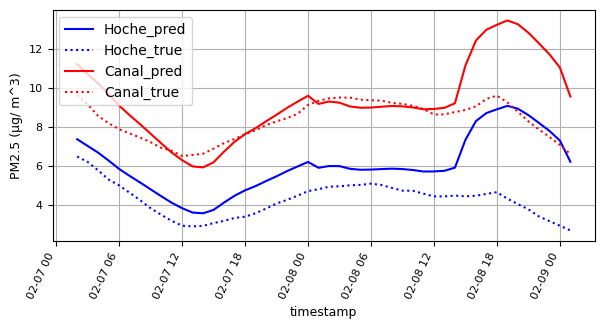

In [162]:
timeseris_plot3(df_0, pre_len, seq_len, n_train, y_train_true, y_train_prd,
                 y_test_true, y_test_prd, 0, title='Two-Day PM2.5 Forecasting for Canal Site: Next-Hour Forecasting')

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

input_ = Input((trainX.shape[1], trainX.shape[2]))
x = LSTM(128, activation='sigmoid', return_sequences=True)(input_)  ## the best between 64 to 128 /relu then sigmoid
x = LSTM(128, activation='sigmoid', return_sequences=False)(x)
x = Dropout(0.2)(x)

output_ = Dense(4)(x)

In [ ]:

model_ = Model(inputs=input_ , outputs=output_)
model_.compile(loss='mse', optimizer=optimizer)
model_.summary()

start_time = time.time()

earlyStop=EarlyStopping(monitor="val_loss",verbose=2, mode='min', patience=30)
# fit network
history_ = model_.fit(trainX, trainY, epochs=200, batch_size=48, 
                    validation_data=(testX, testY), verbose=1, shuffle=False, callbacks=[earlyStop])

print("--- %s seconds ---" % round(time.time() - start_time))
# plot history
plt.plot(history_.history['loss'], label='train')
plt.plot(history_.history['val_loss'], label='test')

plt.xlabel('Epochs')
plt.ylabel('loss value')
plt.legend()
plt.title('loss: '+str(seq_len)+' hour(s) forcasting ' + 'with ' + str(pre_len) + ' hour(s) of observation', fontsize=12)

plt.show()